In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import os
import math
import scipy.stats as stats
import json
import pysam
from matplotlib.transforms import Affine2D
import mpl_toolkits.axisartist.floating_axes as floating_axes
from mpl_toolkits.axisartist.grid_finder import DictFormatter
from matplotlib.patches import Rectangle
from basenji import dataset, dna_io, seqnn
import cooler
import matplotlib.font_manager as font_manager

sns.set(palette='husl', context = 'talk', style='white', font_scale=1)
BASE_PATH = "/".join(os.getcwd().split("/")) # base directory level

BIN_PATH = os.path.join(BASE_PATH, "bin")  # where my scripts live
DATA_PATH = os.path.join(BASE_PATH, "data")  # where I dump new data 
RESULTS_PATH = os.path.join(BASE_PATH, "results")  # where I analyze results

SRC_PATH = os.path.join(BASE_PATH, "src")  # where any packages needed to run analyses live. I haven't started structuring things this way yet. 

COMP_PATH = os.path.join(DATA_PATH,"pairwise/hsmrca")
COMP_PATH = os.path.join(DATA_PATH,"pairwise/reference")

EXP_PATH = os.path.join(RESULTS_PATH, "expectedDiv")


In [3]:
from cooltools.lib.numutils import observed_over_expected, adaptive_coarsegrain
from cooltools.lib.numutils import interpolate_bad_singletons, interp_nan
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve

/wynton/home/capra/egilbertson/.conda/envs/modern3d/lib/python3.9/site-packages/cooltools/lib/numutils.py:652: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def iterative_correction_symmetric(
/wynton/home/capra/egilbertson/.conda/envs/modern3d/lib/python3.9/site-packages/cooltools/lib/numutils.py:727: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def iterative_

In [4]:
# RESULTS_PATH

In [5]:
arial_path = '/wynton/home/capra/egilbertson/.conda/envs/modern3d/fonts/Arial.ttf'
arial = font_manager.FontProperties(fname = arial_path)

# Functions

In [6]:
def simple_map_comparison(ind1, ind2, window, sat = 1):
    chr = window[0]
    start = int(window[1])
    ind1_mat = from_upper_triu(ind1, 448, 2)
    mask =  np.tri(ind1_mat.shape[0], k = -1)
    ind1_mat = np.ma.array(ind1_mat, mask = mask).T
    
    ind2_mat = from_upper_triu(ind2, 448, 2)
    mask =  np.tri(ind2_mat.shape[0], k = -1)
    ind2_mat = np.ma.array(ind2_mat, mask = mask).T


    fig1, axes = plt.subplots(3, 1, figsize=(40,20))

    fig1.delaxes(axes[0])
    fig1.delaxes(axes[1])
    fig1.delaxes(axes[2])
    
    ax0 = setup_axes1(fig1, 311, -45)
    ax1 = setup_axes1(fig1, 312, -45)
    ax2 = setup_axes1(fig1, 313, -45)

    # ax0.set_position([0, 0.62, 1, 1])
    # ax1.set_position([0, 0.31, 1, 1])
    # ax2.set_position([0, 0, 1, 1])
    
    ax0.matshow(ind1_mat, cmap = 'RdBu_r', vmin = -sat, vmax = sat)
    ax1.matshow(ind2_mat, cmap = 'RdBu_r', vmin = -sat, vmax = sat)
    ax2.matshow(ind2_mat - ind1_mat, cmap = 'PRGn_r', vmin = -(sat/2), vmax = (sat/2))
    
    subplots = [ax0,ax1,ax2]
    
    # add border to map
    for n in subplots:
        n.plot([-1, 447], [0, 448], color = 'black', linewidth = 0.70821529745) # bottom line
        n.plot([-1, 447], [448, 448], color = 'black', linewidth = 0.70821529745) # right line
        n.plot([-1, -1], [448, 0], color = 'black', linewidth = 0.70821529745) # left line
    
    # add 'x-axis' ticks
    first = start + 65536
    rounded = math.ceil(first / 100000) * 100000
    diff = rounded - first
    cell = diff/2048
    
    x_list = np.arange(cell, 440, (100000/2048))
        
    for n in subplots:
        for x in x_list:
            n.plot(x, x, color = 'black', marker = '|', markersize = 5)
    
    # add 'x-axis' labels
    y_list = np.arange((rounded/1000000), ((rounded/1000000)+0.9), 0.1)
    for n in subplots:
        for x, y in zip(x_list[::2], (y_list[::2])):
            n.text(x+15, x-15, '%.1f' % y, horizontalalignment = 'center', verticalalignment = 'top', fontproperties = arial, fontsize = 9)
    
    # subpanel labels
    ax0.text(290, 158, 'idw', horizontalalignment = 'center', verticalalignment = 'center', fontproperties = arial, fontsize = 10)
    ax1.text(290, 158, 'ancestor', horizontalalignment = 'center', verticalalignment = 'center', fontproperties = arial, fontsize = 10)
    ax2.text(290, 158, r'$\Delta$', horizontalalignment = 'center', verticalalignment = 'center', fontproperties = arial, fontsize = 10)
    
    #plt.savefig('/wynton/group/capra/projects/pan_3d_genome/figures/map_comparisons/simple_comparison_%s_%s_%s.pdf' % (window, ind1, ind2), bbox_inches = 'tight', transparent = True, dpi = 400);
    plt.show()

In [7]:


def get_target(chrom,start,end,genome_hic_cool, pool):
    pool_width = pool
    crop_bp = 65536
    diagonal_offset = 2
    kernel_stddev = 1
    clip = 2
    seq_len_nt = end - start
    seq_len_pool = seq_len_nt // pool_width
    crop_start = crop_bp // pool_width
    crop_end = seq_len_pool - crop_start
    seq_len_crop = seq_len_pool - 2*crop_start
    triu_tup = np.triu_indices(seq_len_crop, diagonal_offset)
    seq_len_nodiag = seq_len_crop - diagonal_offset
    seq_len_hic = seq_len_nodiag*(seq_len_nodiag + 1) // 2
    ## based on Aktia paper, this line should be "kernel = Gaussian2DKernel(x_stddev=kernel_stddev,x_size=5)";
    ## however, on basenji github, it is "kernel = Gaussian2DKernel(x_stddev=kernel_stddev)", 
    ## I tested both and found there was no significant difference, but you can retest it
    #kernel = Gaussian2DKernel(x_stddev=kernel_stddev)
    kernel = Gaussian2DKernel(x_stddev=kernel_stddev,x_size=5)
    
    mseq_str = '%s:%d-%d' % (chrom, start, end)
    seq_hic_raw = genome_hic_cool.matrix(balance=True).fetch(mseq_str)
    seq_hic_nan = np.isnan(seq_hic_raw)
    num_filtered_bins = np.sum(np.sum(seq_hic_nan,axis=0) == len(seq_hic_nan))
    print(len(seq_hic_nan))
    if num_filtered_bins > (.5*len(seq_hic_nan)):
        print("WARNING: %s >50 percent bins filtered, check:  %s. " % ('name', mseq_str))
    
    clipval = np.nanmedian(np.diag(seq_hic_raw,diagonal_offset))
    for i in range(-diagonal_offset+1,diagonal_offset):
        set_diag(seq_hic_raw, clipval, i)
    seq_hic_raw = np.clip(seq_hic_raw, 0, clipval)
    seq_hic_raw[seq_hic_nan] = np.nan
    
    seq_hic_smoothed = adaptive_coarsegrain(
                            seq_hic_raw,
                            genome_hic_cool.matrix(balance=False).fetch(mseq_str),
                            cutoff=2, max_levels=8)
    seq_hic_nan = np.isnan(seq_hic_smoothed)
    
    seq_hic_obsexp = observed_over_expected(seq_hic_smoothed, ~seq_hic_nan)[0]
    seq_hic_obsexp = np.log(seq_hic_obsexp)
    seq_hic_obsexp = np.clip(seq_hic_obsexp, -clip, clip)
    seq_hic_obsexp = interp_nan(seq_hic_obsexp)
    for i in range(-diagonal_offset+1, diagonal_offset): set_diag(seq_hic_obsexp, 0,i)
    seq_hic = convolve(seq_hic_obsexp, kernel)
    
    seq_hic = seq_hic[crop_start:crop_end,:]
    seq_hic = seq_hic[:,crop_start:crop_end]
    print(triu_tup)
    print(seq_hic.shape)
    seq_hic = seq_hic[triu_tup].astype('float16')
    print(seq_hic.shape)
    return seq_hic


In [8]:
def loadAkita():
    os.environ["CUDA_VISIBLE_DEVICES"] = '-1'

    import tensorflow as tf
    if tf.__version__[0] == '1':
        tf.compat.v1.enable_eager_execution()

    with open('/wynton/group/capra/projects/modern_human_3Dgenome/bin/basenji/manuscripts/akita/params.json') as params_file:
        params = json.load(params_file)
        params_model = params['model']
        params_train = params['train']
        
    global seqnn_model
    seqnn_model = seqnn.SeqNN(params_model)
    seqnn_model.restore('/wynton/group/capra/projects/modern_human_3Dgenome/bin/basenji/manuscripts/akita/model_best.h5')

In [9]:
def from_upper_triu(vector_repr, matrix_len, num_diags):
    z = np.zeros((matrix_len,matrix_len))
    triu_tup = np.triu_indices(matrix_len,num_diags)
    z[triu_tup] = vector_repr
    for i in range(-num_diags+1,num_diags):
        set_diag(z, np.nan, i)
    return z + z.T

def set_diag(arr, x, i=0):
    start = max(i, -arr.shape[1] * i)
    stop = max(0, (arr.shape[1] - i)) * arr.shape[1]
    step = arr.shape[1] + 1
    arr.flat[start:stop:step] = x
    return arr

def setup_axes1(fig, rect, angle):
    tr = Affine2D().scale(2, 2).rotate_deg(angle)

    #We create dictionarys to keep the xticks and yticks after the rotation
    dictio={i:str(val) for i,val in enumerate(np.arange(-.5, 449, 10).tolist())}
    reversedictio={i:dictio[val] for i,val in enumerate(list(reversed(sorted(dictio.keys()))))}
    grid_helper = floating_axes.GridHelperCurveLinear(
        tr, extremes=(-0.5, 448.5,-0.5, 448.5), tick_formatter1= DictFormatter(dictio),
        tick_formatter2=DictFormatter(reversedictio))

    ax1 = floating_axes.FloatingSubplot(fig, rect, grid_helper=grid_helper)
    
    # remove axes
    ax1.axis("off")    
    ax1.axis["bottom"].set_visible(False)
    ax1.axis["top"].set_visible(False)
    ax1.axis["right"].set_visible(False)
    ax1.axis["left"].set_visible(False)


    fig.add_subplot(ax1) 
    aux_ax = ax1.get_aux_axes(tr)
    grid_helper.grid_finder.grid_locator1._nbins = 448    #Number of rows
    grid_helper.grid_finder.grid_locator2._nbins = 448    #Number of columns
    return aux_ax

In [10]:
def runAkitaPreds(seq):
    if len(seq) != 2**20: raise ValueError('len(seq) != seq_length')
    seq_1hot = dna_io.dna_1hot(seq)
    test_pred_from_seq = seqnn_model.model.predict(np.expand_dims(seq_1hot,0))
    return test_pred_from_seq

In [11]:
def get_ref_seq_hg19(chr, window_start):
    ref_fasta_open = pysam.Fastafile('/wynton/group/capra/projects/modern_human_3Dgenome/data/genomes/hg38_reference.fa')

    ref_seq = ref_fasta_open.fetch(chr, int(window_start), int(window_start)+2**20).upper()

    return ref_seq

In [12]:
def get_ref_seq_hg38(chr, window_start):
    ref_fasta_open = pysam.Fastafile('/wynton/group/capra/projects/modern_human_3Dgenome/data/genomes/hg38_reference.fa')

    ref_seq = ref_fasta_open.fetch(chr, int(window_start), int(window_start)+2**20).upper()

    return ref_seq

In [13]:
def load_1kg_map(chr, start, ind):
    with open('/wynton/group/capra/projects/modern_human_3Dgenome/data/akitaPreds/3dpreds/HFF_original/3dpreds_%s.txt' % (ind)) as file:
        lines = [ line.strip() for line in file ]
        for line in lines:
            if '%s' % (chr) in line and '%s' % (start) in line:
                ind2_vector = line.split('\t')
                ind2_vector = ind2_vector[2:]
    return ind2_vector

In [14]:
def get_anc_seq(chr, window_start):
    anc_fasta_open = pysam.Fastafile('/wynton/group/capra/projects/modern_human_3Dgenome/data/genomes/human_archaic_ancestor/human_archaic_ancestor_in_hg38_%s.fasta' % chr)

    anc_seq = anc_fasta_open.fetch(chr, int(window_start), int(window_start)+2**20).upper()

    return anc_seq

In [15]:
def get_seq(chr, window_start, variant_pos, alt_allele, base = 'anc'):
    if base == 'ref':
        base_seq = get_ref_seq_hg38(chr, window_start)
    elif base == 'anc':
        base_seq = get_anc_seq(chr, window_start)

    pos_in_window = (int(variant_pos)-1)-int(window_start)
    alt_seq = base_seq[0:pos_in_window] + alt_allele + base_seq[pos_in_window+1:]

    return alt_seq

In [16]:
def comparePreds(ref, alt):
    mse = np.mean(np.square(ref - alt))
    spearman = stats.spearmanr(ref, alt)[0]
    divergence = 1 - spearman
    return (mse, divergence)

In [17]:
def visualize_map(pred, window_start, indi, chrm, s=448, cbar=False, sat=1):
    ind1_mat = from_upper_triu(pred, s, 2)
    mask =  np.tri(ind1_mat.shape[0], k = -1) # bottom-half
    ind1_mat = np.ma.array(ind1_mat, mask = mask).T # transpose

    # rotate matrix and add color
    if cbar: 
        fig1, axes=plt.subplots(1,figsize=(4,3))
    else:
        fig1, axes=plt.subplots(1,figsize=(3,3)) 
    fig1.delaxes(axes)
    ax = setup_axes1(fig1, 111, -45)

    _ = ax.matshow(ind1_mat, cmap = 'RdBu_r', vmin = -sat, vmax=sat)
    if cbar:
        c = fig1.colorbar(_, location='bottom', orientation = 'horizontal', shrink=0.4)
        for l in c.ax.xaxis.get_ticklabels():
            l.set_fontproperties(arial)
            l.set_size(10)
    #plt.matshow(ind1_mat, cmap = 'RdBu_r')

    # add border to map
    ax.plot([-1, s-1], [0, s], color = 'black', linewidth = 1) # bottom line
    ax.plot([-1, s-1], [s, s], color = 'black', linewidth = 1) # right line
    ax.plot([-1, -1], [s, 0], color = 'black', linewidth = 1) # left line

    # add 'x-axis' ticks
    first = window_start + 65536
    rounded = math.ceil(first / 100000) * 100000
    diff = rounded - first
    cell = diff/2048
    
    x_list = np.arange(cell, 440, (100000/2048))
    for x in x_list:
        ax.plot(x, x, color = 'black', marker = '|', markersize = 5)
        
    # add 'x-axis' labels
    y_list = np.arange((rounded/1000000), ((rounded/1000000)+0.9), 0.1)
    for x, y in zip(x_list[::2], (y_list[::2])):
            ax.text(x+15, x-15, '%.1f' % y, horizontalalignment = 'center', verticalalignment = 'top', fontproperties = arial, fontsize = 10)

    ax.text(0, -30, chrm, horizontalalignment = 'right', verticalalignment = 'top', fontproperties = arial, fontsize = 10)

    ax.text(290, 140, indi, horizontalalignment = 'center', verticalalignment = 'center', fontproperties = arial, fontsize = 10)
    plt.savefig("results/plots/individual_maps/%s_%s_%s.svg" % (indi, chrm, str(window_start)), bbox_inches = 'tight')
    plt.show()
    
    
    return ind1_mat


In [18]:

def setup_axes1_exp(fig, rect, angle):
    tr = Affine2D().scale(2, 2).rotate_deg(angle)

    #We create dictionarys to keep the xticks and yticks after the rotation
    dictio={i:str(val) for i,val in enumerate(np.arange(-.5, 449, 10).tolist())}
    reversedictio={i:dictio[val] for i,val in enumerate(list(reversed(sorted(dictio.keys()))))}
    grid_helper = floating_axes.GridHelperCurveLinear(
        tr, extremes=(-0.5, 918.5,-0.5, 918.5), tick_formatter1= DictFormatter(dictio),
        tick_formatter2=DictFormatter(reversedictio))

    ax1 = floating_axes.FloatingSubplot(fig, rect, grid_helper=grid_helper)
    
    # remove axes
    ax1.axis("off")    
    ax1.axis["bottom"].set_visible(False)
    ax1.axis["top"].set_visible(False)
    ax1.axis["right"].set_visible(False)
    ax1.axis["left"].set_visible(False)


    fig.add_subplot(ax1) 
    aux_ax = ax1.get_aux_axes(tr)
    grid_helper.grid_finder.grid_locator1._nbins = 918    #Number of rows
    grid_helper.grid_finder.grid_locator2._nbins = 918    #Number of columns
    return aux_ax



def visualize_map_exp(pred, window_start, chrm, s=448, cbar=False, sat = 1):
    ind1_mat = from_upper_triu(pred, s, 2)
    mask =  np.tri(ind1_mat.shape[0], k = -1) # bottom-half
    ind1_mat = np.ma.array(ind1_mat, mask = mask).T # transpose

    # rotate matrix and add color
    if cbar: 
        fig1, axes=plt.subplots(1,figsize=(4,3))
    else:
        fig1, axes=plt.subplots(1,figsize=(4,4)) 
    fig1.delaxes(axes)
    ax = setup_axes1_exp(fig1, 111, -45)

    _ = ax.matshow(ind1_mat, cmap = 'RdBu_r', vmin = -sat, vmax=sat)
    if cbar:
        c = fig1.colorbar(_, location='bottom', orientation = 'horizontal', shrink=0.4)
        for l in c.ax.xaxis.get_ticklabels():
            l.set_fontproperties(arial)
            l.set_size(10)
    #plt.matshow(ind1_mat, cmap = 'RdBu_r')

    # add border to map
    ax.plot([-1, s-1], [0, s], color = 'black', linewidth = 1) # bottom line
    ax.plot([-1, s-1], [s, s], color = 'black', linewidth = 1) # right line
    ax.plot([-1, -1], [s, 0], color = 'black', linewidth = 1) # left line

    # add 'x-axis' ticks
    first = window_start + 65536
    rounded = math.ceil(first / 100000) * 100000
    diff = rounded - first
    cell = diff/1000
    
    x_list = np.arange(cell, 918, (100000/1000))
    for x in x_list:
        ax.plot(x, x, color = 'black', marker = '|', markersize = 5)
        
    # add 'x-axis' labels
    y_list = np.arange((rounded/1000000), ((rounded/1000000)+0.9), 0.1)
    for x, y in zip(x_list[::2], (y_list[::2])):
            ax.text(x+15, x-15, '%.1f' % y, horizontalalignment = 'center', verticalalignment = 'top', fontproperties = arial, fontsize = 10)

    ax.text(0, -30, chrm, horizontalalignment = 'right', verticalalignment = 'top', fontproperties = arial, fontsize = 10)

    ax.text(450, 150, 'GM12878 Experimental', fontproperties = arial, fontsize = 10)#, horizontalalignment = 'center', verticalalignment = 'bottom', fontproperties = arial, fontsize = 10)
    #plt.savefig("results/plots/individual_maps/%s_%s_%s.svg" % (indi, chrm, str(window_start)), bbox_inches = 'tight')
    plt.show()
    
    
    return ind1_mat


In [19]:
def map_comparison_IDW_prediction(ref_pred, idw_pred, mut_pred, chr, start, variant):

    ref_mat = from_upper_triu(ref_pred, 448, 2)
    mask =  np.tri(ref_mat.shape[0], k = -1)
    ref_mat = np.ma.array(ref_mat, mask = mask).T
    

    idw_mat = from_upper_triu(idw_pred, 448, 2)
    mask =  np.tri(idw_mat.shape[0], k = -1)
    idw_mat = np.ma.array(idw_mat, mask = mask).T
    

    mut_mat = from_upper_triu(mut_pred, 448, 2)
    mask =  np.tri(mut_mat.shape[0], k = -1)
    mut_mat = np.ma.array(mut_mat, mask = mask).T

# plot

    fig1, axes=plt.subplots(3, 1, figsize=(10,20))
    
    fig1.delaxes(axes[0])
    fig1.delaxes(axes[1])
    fig1.delaxes(axes[2])
    
    ax0 = setup_axes1(fig1, 311, -45)
    ax1 = setup_axes1(fig1, 312, -45)
    ax2 = setup_axes1(fig1, 313, -45)

    ax0.set_position([0, 0, 1, 1])
    ax1.set_position([0, 0.33, 1, 1])
    ax2.set_position([0, 0, 1, 1])

    ax0.matshow(ref_mat, cmap = 'RdBu_r', vmin=-0.6, vmax=0.6)
    ax1.matshow(idw_mat, cmap = 'RdBu_r', vmin=-0.6, vmax=0.6)
    ax2.matshow(mut_mat, cmap = 'RdBu_r', vmin=-0.6, vmax=0.6)


    subplots = [ax0,ax1,ax2]
    
    # add border to map
    for n in subplots:
        n.plot([-1, 447], [0, 448], color = 'black', linewidth = 1) # bottom line
        n.plot([-1, 447], [448, 448], color = 'black', linewidth = 1) # right line
        n.plot([-1, -1], [448, 0], color = 'black', linewidth = 1) # left line
    
    # add 'x-axis' ticks
    first = start + 65536
    rounded = math.ceil(first / 100000) * 100000
    diff = rounded - first
    cell = diff/2048
    
    x_list = np.arange(cell, 440, (100000/2048))
        
    for n in subplots:
        for x in x_list:
            n.plot(x, x, color = 'black', marker = '|', markersize = 15 * 0.75)
    
    # add 'x-axis' labels
    y_list = np.arange((rounded/1000000), ((rounded/1000000)+0.9), 0.1)
    for n in subplots:
        for x, y in zip(x_list[::2], (y_list[::2])):
            n.text(x+21, x-21, '%.1f' % y, horizontalalignment = 'center', verticalalignment = 'top', fontsize = 9)
    
    # variant position
    variant_diff = variant - first
    variant_cell = variant_diff/2048
    
    for n in subplots:
        n.scatter(variant_cell+9, variant_cell-9, marker = '*', s = 150, c = '#d80000', edgecolors = 'none', zorder = 10)
        n.scatter(variant_cell+9, variant_cell-9, marker = '*', s = 150, c = 'none', edgecolors = 'black', linewidths = 1, zorder = 8)

    #get annotations
    gene_starts, gene_lengths, gene_midpoints, exon_genes, phastCons_starts, phastCons_lengths, CTCF_starts, CTCF_lengths = annotations(chr, start)
    #,exon_starts, exon_lengths
    # plot tracks
    # for x, y in zip(exon_starts, exon_lengths):
    #     ax2.add_patch(Rectangle((x+70, x-70), width = y, height = 25 * 0.75, angle = 45, color = 'black', lw = 1))
    for x, y in zip(gene_starts, gene_lengths):
        ax2.plot([(x+63.5), ((x+y)+63.5)],[(x-63.5), ((x+y)-63.5)], color = 'black') # line will default to bottom of exon rectangle so adjust coordinates if exon height changes
    for x, y in zip(gene_midpoints, exon_genes):
        ax2.text(x+75, x-75, y, horizontalalignment = 'center', verticalalignment = 'top', style = 'italic', fontsize = 7)
    for x, y in zip(CTCF_starts, CTCF_lengths):
        ax2.add_patch(Rectangle((x+115, x-115), width = y, height = 25 * 0.75, angle = 45, color = 'grey', lw = 1))
    for x, y in zip(phastCons_starts, phastCons_lengths):
        ax2.add_patch(Rectangle((x+145, x-145), width = y, height = 25 * 0.75, angle = 45, color = 'goldenrod', lw = 1))

    # track labels
    for n in subplots:
        n.text(0, -42, chr, horizontalalignment = 'right', verticalalignment = 'top', fontsize = 10)
    ax2.text(37.5, -82.5, 'Genes', horizontalalignment = 'right', verticalalignment = 'center', fontsize = 10)
    ax2.text(87.5, -127.5, 'CTCF', horizontalalignment = 'right', verticalalignment = 'center', fontsize = 10)
    ax2.text(117.5, -157.5, 'Cons', horizontalalignment = 'right', verticalalignment = 'center', fontsize = 10)


    # subpanel labels
    ax0.text(275, 180, 'Reference', horizontalalignment = 'center', verticalalignment = 'center', fontsize = 15)
    ax1.text(282, 180, '1 KG Individual', horizontalalignment = 'center', verticalalignment = 'center',  fontsize = 15)
    ax2.text(279, 180, 'Mutated Reference', horizontalalignment = 'center', verticalalignment = 'center', fontsize = 15)
    
    plt.savefig('results/plots/ism_common_example_%s_%s.svg' % (chr, start), bbox_inches = 'tight');
    
    plt.show()

In [20]:
!pwd

/wynton/group/capra/projects/modern_human_3Dgenome


In [21]:
def map_comparison_IDW_prediction_difference(ref_pred, alt_pred, chr, start, variant, arrow_star):

    ref_mat = from_upper_triu(ref_pred, 448, 2)
    mask =  np.tri(ref_mat.shape[0], k = -1)
    ref_mat = np.ma.array(ref_mat, mask = mask).T
    

    alt_mat = from_upper_triu(alt_pred, 448, 2)
    mask =  np.tri(alt_mat.shape[0], k = -1)
    alt_mat = np.ma.array(alt_mat, mask = mask).T
    


# plot

    fig1, axes=plt.subplots(3, figsize=(40,20))
    
    fig1.delaxes(axes[0])
    fig1.delaxes(axes[1])
    fig1.delaxes(axes[2])
    
    ax0 = setup_axes1(fig1, 131, -45)
    ax1 = setup_axes1(fig1, 132, -45)
    ax2 = setup_axes1(fig1, 133, -45)
    
    ax0.matshow(ref_mat, cmap = 'RdBu_r')
    ax1.matshow(alt_mat, cmap = 'RdBu_r')
    ax2.matshow(ref_mat - alt_mat, cmap = 'PRGn_r')
    

    subplots = [ax0,ax1,ax2]
    
    # add border to map
    for n in subplots:
        n.plot([-1, 447], [0, 448], color = 'black', linewidth = 3.5) # bottom line
        n.plot([-1, 447], [448, 448], color = 'black', linewidth = 3.5) # right line
        n.plot([-1, -1], [448, 0], color = 'black', linewidth = 3.5) # left line
    
    # add 'x-axis' ticks
    first = start + 65536
    rounded = math.ceil(first / 100000) * 100000
    diff = rounded - first
    cell = diff/2048
    
    x_list = np.arange(cell, 440, (100000/2048))
        
    for n in subplots:
        for x in x_list:
            n.plot(x, x, color = 'black', marker = '|', markersize = 15)
    
    # add 'x-axis' labels
    y_list = np.arange((rounded/1000000), ((rounded/1000000)+0.9), 0.1)
    for n in subplots:
        for x, y in zip(x_list[::2], (y_list[::2])):
            n.text(x+15, x-15, '%.1f' % y, horizontalalignment = 'center', verticalalignment = 'top', fontsize = 32)
    
    # variant position
    variant_diff = variant - first
    variant_cell = variant_diff/2048
    
    if arrow_star:
    # arrow
        for n in subplots:
            n.arrow(x = variant_cell-50, y = variant_cell+50, dx = 40, dy = -40, width = 10, length_includes_head = True, head_length = 17.5, edgecolor = 'black', facecolor = 'black')
        
        for n in subplots:
            n.plot(variant_cell+10, variant_cell-10, color = 'black', marker = '*', markersize = 20)
    
    #plt.savefig('../plots/map_comparisons/IDW_%s_%s_%s_%s.pdf' % (ref, ind2, chr, start), bbox_inches = 'tight');
    
    plt.show()

In [22]:
def annotations(chr, start):
    # assign a few variables for the "tracks" below
    map_x_min = (start+65536)
    map_x_max = (start+((2**20)-65536))
            
    # exons
    # exons = pd.read_csv('/wynton/group/capra/projects/pan_3d_genome/data/annotations/panTro6_exons.bed', sep = '\t', header = None, names = ['chr','start','end','gene'])
    # exons = exons[(exons['chr'] == chr) & (exons['start'] >= start) & (exons['start'] < map_x_max)]
    # exons['end'].values[exons['end'] > map_x_max] = map_x_max
    
    # exons['start'] = (exons['start'] - (start + 65536)) / 2048
    # exons['end'] = (exons['end'] - (start + 65536)) / 2048
    # exons['length'] = exons['end'] - exons['start']
    # exons = exons[exons['end'] >= 0] # remove values less than zero
    
    # exon_genes = pd.unique(exons['gene']).tolist()
    # exon_starts = exons['start'].values.tolist()
    # exon_lengths = exons['length'].values.tolist()

    # genes
    genes = pd.read_csv('/wynton/group/capra/projects/modern_human_3Dgenome/data/annotations/grch38_gene_annotations.bed', sep = '\t', header = None, names = ['chr','start','end','gene'], skiprows=1)
    genes = genes[(genes['chr'] == chr) & (genes['start'] >= start) & (genes['start'] < map_x_max)]
    exon_genes = pd.unique(genes['gene']).tolist()
    genes = genes[genes['gene'].isin(exon_genes)]
    
    genes['start'].values[genes['start'] < map_x_min] = map_x_min
    genes['end'].values[genes['end'] > map_x_max] = map_x_max
    genes['start'] = (genes['start'] - map_x_min) / 2048
    genes['end'] = (genes['end'] - map_x_min) / 2048
  
    genes['length'] = genes['end'] - genes['start']
    gene_starts = genes['start'].values.tolist()
    gene_lengths = genes['length'].values.tolist()
    
    # gene names
    gene_midpoints = (genes['length']/2) + genes['start'].values.tolist()

    # phastCons
    phastCons = pd.read_csv('/wynton/group/capra/projects/modern_human_3Dgenome/data/annotations/phastConsElements100way_hg38.bed', sep = '\t', header = None, names = ['chr','start','end','name','score'], skiprows=1)
    phastCons = phastCons[(phastCons['chr'] == chr) & (phastCons['start'] >= start) & (phastCons['start'] < start+((2**20)-65536))]
    phastCons['end'].values[phastCons['end'] > map_x_max] = map_x_max
    phastCons['start'] = (phastCons['start'] - (start + 65536)) / 2048
    phastCons['end'] = (phastCons['end'] - (start + 65536)) / 2048
    phastCons['length'] = phastCons['end'] - phastCons['start']
    phastCons_starts = phastCons['start'].values.tolist()
    phastCons_lengths = phastCons['length'].values.tolist()
    
    # CTCF
    CTCF = pd.read_csv('/wynton/group/capra/projects/modern_human_3Dgenome/data/annotations/ctcf_full_merged_hg38.bed', sep = '\t', header = None, names = ['chr','start','end'])
    CTCF = CTCF[(CTCF['chr'] == chr) & (CTCF['start'] >= start) & (CTCF['start'] < start+((2**20)-65536))]
    CTCF['end'].values[CTCF['end'] > map_x_max] = map_x_max
    CTCF['start'] = (CTCF['start'] - (start + 65536)) / 2048
    CTCF['end'] = (CTCF['end'] - (start + 65536)) / 2048
    CTCF['length'] = CTCF['end'] - CTCF['start']
    CTCF_starts = CTCF['start'].values.tolist()
    CTCF_lengths = CTCF['length'].values.tolist()


    return gene_starts, gene_lengths, gene_midpoints, exon_genes, phastCons_starts, phastCons_lengths, CTCF_starts, CTCF_lengths #,exon_starts, exon_lengths 

In [23]:
def exp_more_div_window_comp(chrm, wndw, hic_res, exp_map_dim, sat=1):

    target = get_target(chrm,wndw,wndw + 2**20,genome_hic_cool, hic_res)
    anc_seq = get_anc_seq(chrm, wndw)
    anc_pred = runAkitaPreds(anc_seq)
    anc_pred_hff = anc_pred[:,:,0][0]
    maxi = "_".join(list(anc_div.loc[chrm].loc[wndw].idxmax()))
    mini = "_".join(list(anc_div.loc[chrm].loc[wndw].idxmin()))
    ind_pred_mini = load_1kg_map(chrm, wndw, mini)
    ind_pred_maxi = load_1kg_map(chrm, wndw, maxi)

    val_pred = load_1kg_map(chrm, wndw, 'EUR_CEU_female_NA12878')

    mat = visualize_map_exp(target, wndw, chrm, exp_map_dim, sat=sat)
    _ = visualize_map(anc_pred_hff, wndw, 'Human-Neanderthal Ancestor', chrm, 448, sat=sat)
    _ = visualize_map(val_pred, wndw, 'GM12878 1KG Prediction', chrm, 448, sat=sat)
    _ = visualize_map(ind_pred_mini, wndw, 'minimum divergence from ancestor', chrm, 448, sat=sat)
    _ = visualize_map(ind_pred_maxi, wndw, 'maximum divergence from ancestor', chrm, 448, sat=sat)

    return

# Analysis

In [24]:
loadAkita()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
2024-06-07 14:57:30.530999: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sequence (InputLayer)          [(None, 1048576, 4)  0           []                               
                                ]                                                                 
                                                                                                  
 stochastic_reverse_complement   ((None, 1048576, 4)  0          ['sequence[0][0]']               
 (StochasticReverseComplement)  , ())                                                             
                                                                                                  
 stochastic_shift (StochasticSh  (None, 1048576, 4)  0           ['stochastic_reverse_complement[0
 ift)                                                            ][0]']                     

In [25]:
anc_spear = pd.read_table('%s/comp_tables/anc_window_spearman.csv' % RESULTS_PATH
                    , sep=',', header=[0,1,2,3], index_col=[0,1])
anc_div = 1-anc_spear
windows_to_keep = anc_div.index
anc_div = anc_div.dropna(axis=1)

## examples for schematic figure

In [190]:
anc_div['EUR']['CEU']['female']['NA12878']

chr    windowStartPos
chr1   1048576           0.000303
       1572864           0.000633
       3145728           0.005379
       3670016           0.003560
       4194304           0.006104
                           ...   
chr22  46661632          0.003315
       47185920          0.005605
       47710208          0.103786
       48234496          0.302403
       48758784          0.003768
Name: NA12878, Length: 4873, dtype: float64

In [184]:
anc_div['EUR']['CEU']['female'].loc[chr].loc[window_start].sort_values().head(40).tail(3).head(1).index

Index(['NA12878'], dtype='object')

In [1]:
18350080 + 2**20

19398656

In [166]:
chr = 'chr5'
window_start = 18350080

anc_seq = get_anc_seq(chr, window_start)
anc_pred = runAkitaPreds(anc_seq)
anc_pred_hff = anc_pred[:,:,0][0]

maxi = "_".join(list(anc_div.loc[chr].loc[window_start].idxmax()))
mini = "_".join(list(anc_div.loc[chr].loc[window_start].idxmin()))


ind_pred_max = load_1kg_map(chr, window_start, maxi)
ind_pred_min = load_1kg_map(chr, window_start, mini)
print(maxi, mini)

1/1 [==============================] - 1s 595ms/step


KeyboardInterrupt: 

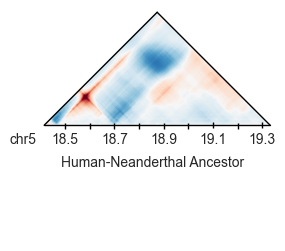

In [168]:
_ = visualize_map(anc_pred_hff, window_start, 'Human-Neanderthal Ancestor', chr, 448)


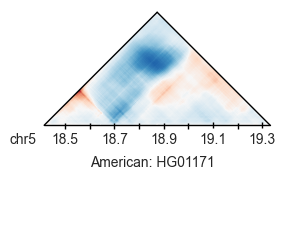

In [169]:

_ = visualize_map(ind_pred_max, window_start, 'American: %s' % maxi.split('_')[-1], chr, 448)

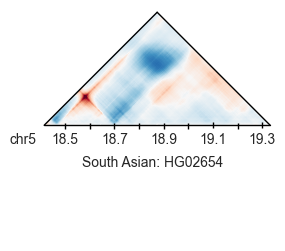

In [170]:

_ = visualize_map(ind_pred_min, window_start, 'South Asian: %s' % mini.split('_')[-1], chr, 448)

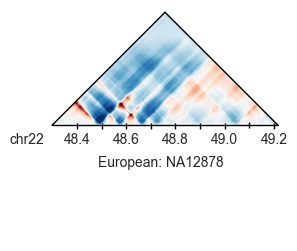

In [192]:
ind_pred = load_1kg_map('chr22', 48234496, 'EUR_CEU_female_NA12878')
_ = visualize_map(ind_pred, 48234496, 'European: %s' % 'EUR_CEU_female_NA12878'.split('_')[-1], 'chr22', 448)

1/1 [==============================] - 1s 1s/step


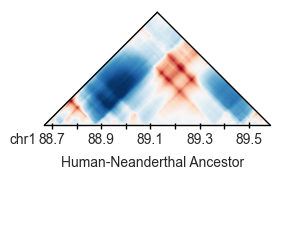

In [106]:
chrm = 'chr1'
wndw = 88604672

anc_seq = get_anc_seq(chrm, wndw)
anc_pred = runAkitaPreds(anc_seq)
anc_pred_hff = anc_pred[:,:,0][0]
_ = visualize_map(anc_pred_hff, wndw, 'Human-Neanderthal Ancestor', chrm, 448, sat = 1.5)


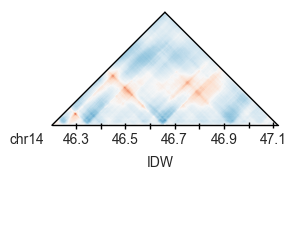

1/1 [==============================] - 1s 1s/step


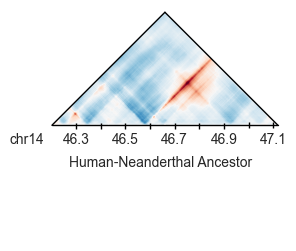

In [52]:
chrm = 'chr14'
wndw = 46137344
sat = 0.5
#ind_pred = load_1kg_map(chrm, wndw, 'AFR_ESN_female_HG02946')
_ = visualize_map(ind_pred, wndw, 'IDW', chrm, 448, sat = sat)

anc_seq = get_anc_seq(chrm, wndw)
anc_pred = runAkitaPreds(anc_seq)
anc_pred_hff = anc_pred[:,:,0][0]
_ = visualize_map(anc_pred_hff, wndw, 'Human-Neanderthal Ancestor', chrm, 448, sat = sat)


## idw examples

In [27]:
anc = pd.read_table('%s/comp_tables/anc_genomewide_averages.csv' % RESULTS_PATH,
                    sep=',', index_col=0)
drops = anc[np.isnan(anc.genome_avg_mse)].index
anc = anc.drop(index=drops)
anc['divergence'] = 1-anc.genome_avg_spearman
anc['full_name'] = anc.index

In [28]:
123740160 + 2**20

124788736

In [90]:
idw_list = pd.read_table("%s/IDWs/idw_mut_params.txt" % DATA_PATH, names = ['chr','window_start','window_end','individual', 'depth'])
comp_list = pd.read_csv('%s/comp_tables/pairwise_subsample_genomewide_averages.csv' % RESULTS_PATH,
                       index_col=0)
all_indivs = sorted(list(set(comp_list.ind1.unique()) | set(comp_list.ind2.unique())))
feng_indivs = ['NA12763', 'HG01982', 'HG00318', 'HG01198']
idw_feng = idw_list[idw_list.individual.isin(list(anc[anc.id.isin(feng_indivs)].full_name))].reset_index(drop=True)
idw_feng

chr  window_start  window_end              individual     depth
0   chr3      64487424    65536000  AMR_PUR_female_HG01198  0.004033
1   chr3      98041856    99090432  AMR_PUR_female_HG01198  0.015840
2   chr4     151519232   152567808  AMR_PUR_female_HG01198  0.013396
3   chr8      98041856    99090432  AMR_PUR_female_HG01198  0.004113
4   chr9      16777216    17825792  AMR_PUR_female_HG01198  0.004521
5  chr17        524288     1572864  AMR_PUR_female_HG01198  0.006671
6  chr17       1048576     2097152  AMR_PUR_female_HG01198  0.012512
7  chr21      29360128    30408704  AMR_PUR_female_HG01198  0.029085

In [94]:
idw_list

chr  window_start  window_end              individual     depth
121   chr1       3670016     4718592  AFR_ASW_female_NA19901  0.016704
115   chr1       6291456     7340032  AFR_ASW_female_NA19625  0.003675
87    chr1       7340032     8388608  SAS_BEB_female_HG04183  0.002926
72    chr1      10485760    11534336  AFR_MSL_female_HG03575  0.019718
72    chr1      11010048    12058624  AFR_MSL_female_HG03575  0.050779
..     ...           ...         ...                     ...       ...
78   chr22      40894464    41943040  SAS_STU_female_HG03673  0.009164
26   chr22      43515904    44564480  AMR_PUR_female_HG01326  0.011355
62   chr22      44564480    45613056  AFR_GWD_female_HG02879  0.025806
54   chr22      45613056    46661632  AFR_ACB_female_HG02555  0.022792
78   chr22      47185920    48234496  SAS_STU_female_HG03673  0.328717

[1251 rows x 5 columns]

In [69]:
len(anc_pred_hff)

99681

In [68]:
len(ind_pred)

99681

/scratch/egilbertson/ipykernel_1325738/3779156700.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ind1_pred = np.array(ind1_pred).astype(np.float)
/scratch/egilbertson/ipykernel_1325738/3779156700.py:11: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ind2_pred = np.array(ind2_pred).astype(np.float)


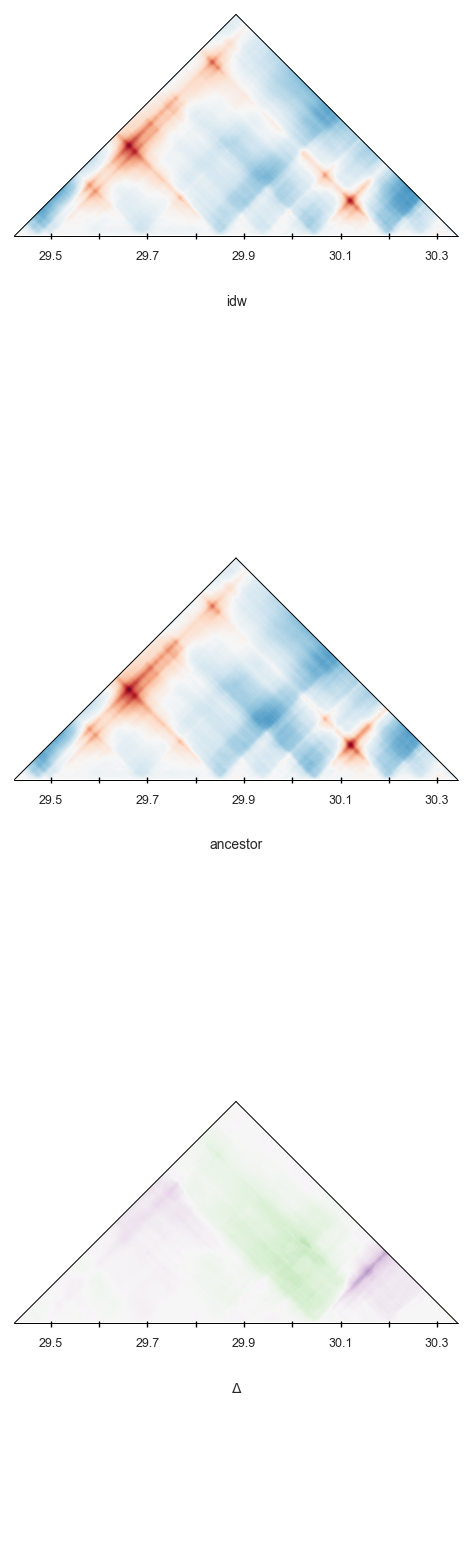

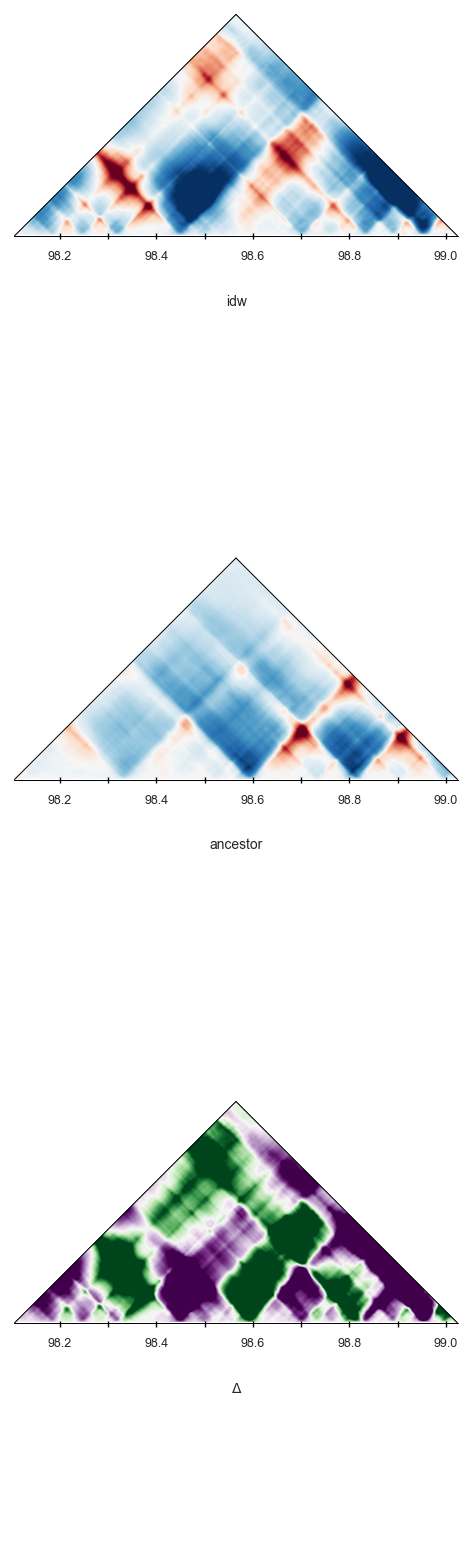

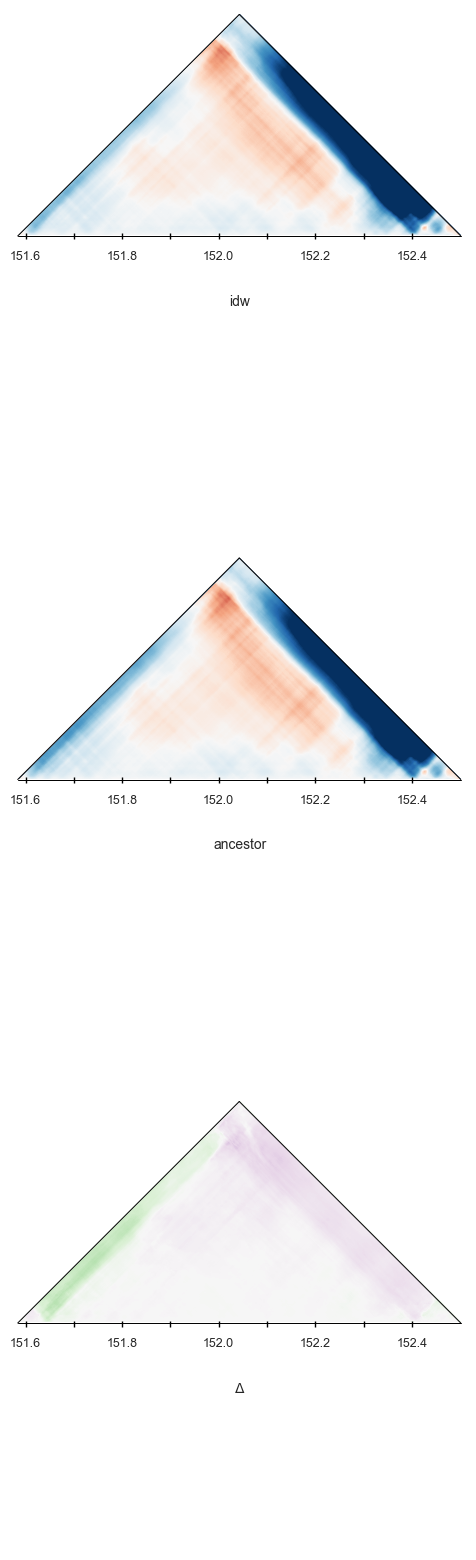

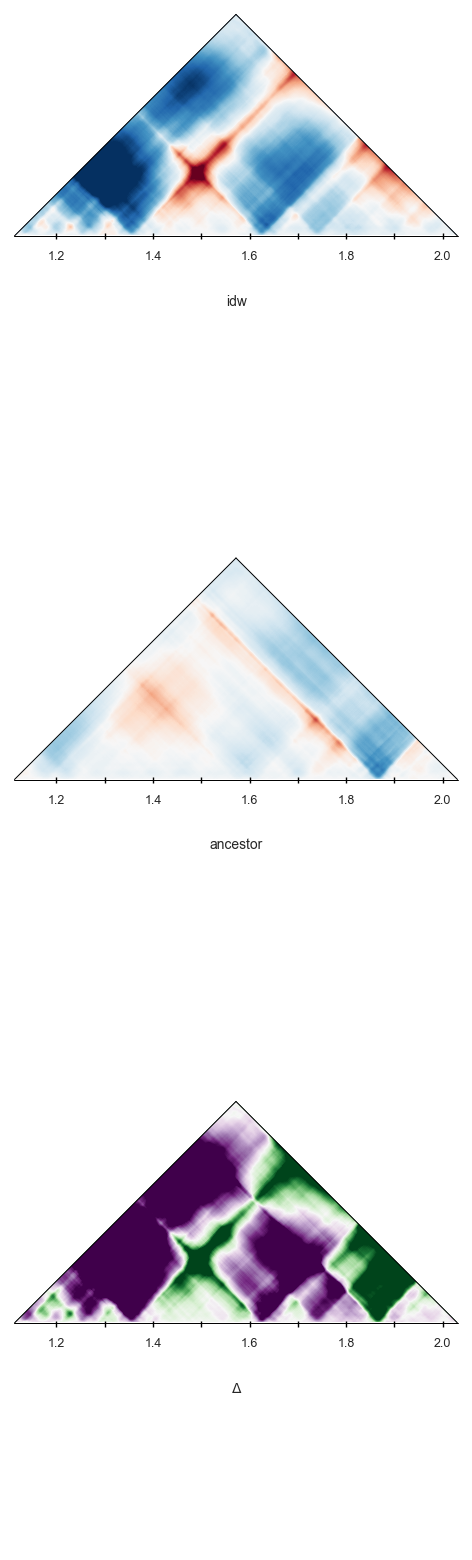

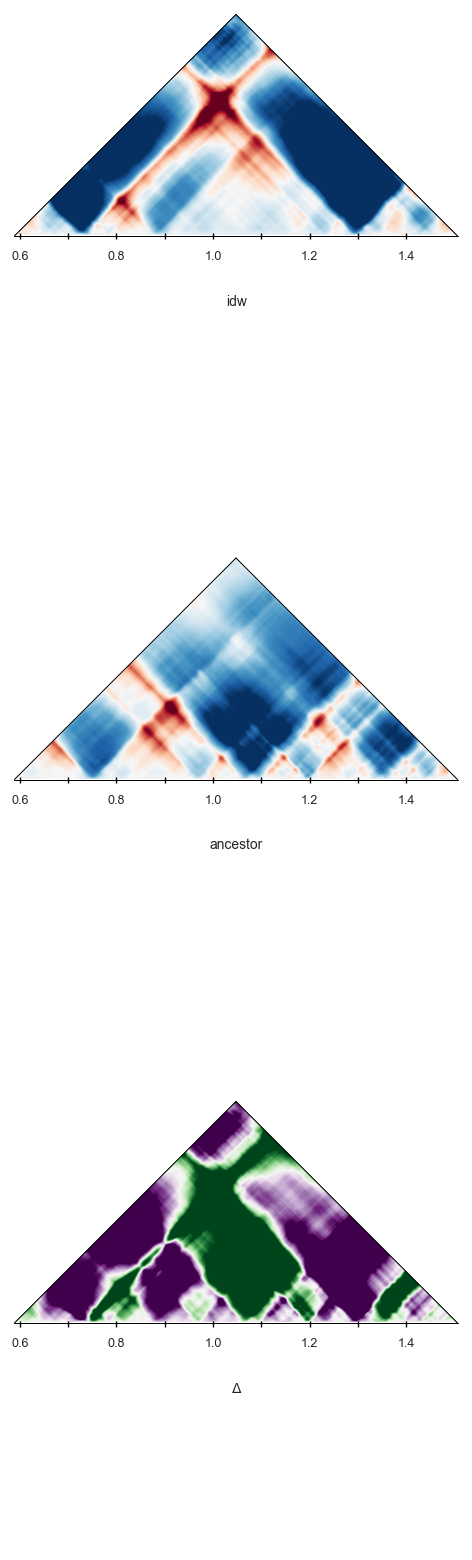

In [100]:


for row in idw_feng.sort_values(by='depth', ascending=False).index[:5]:
    row = idw_feng.iloc[row]
    ind = row.individual
    chrm = row.chr
    wndw = row.window_start
    ind1_pred = load_1kg_map(chrm, wndw, ind)
    ind1_pred = np.array(ind1_pred).astype(np.float)

    non_idw_ind = 'AFR_ASW_female_NA19901'
    ind2_pred = load_1kg_map(chrm, wndw, non_idw_ind)
    ind2_pred = np.array(ind2_pred).astype(np.float)


    simple_map_comparison(ind1_pred, ind2_pred, (chrm, wndw))

In [36]:
chr = 'chr20'
window_start = 41943040
idw_ind = 'AFR_YRI_female_NA19116'
common_ind = 'AFR_MSL_female_HG03086'


In [29]:
chrm = 'chr14'
wndw = 46137344
idw_ind = 'AFR_ESN_female_HG02946'
variant_pos = 46581275
alt_allele = 'A'
ref_pred = load_1kg_map(chrm, wndw, 'hg38_reference')
ref_pred = np.array(ref_pred).astype(np.float)
idw_pred  = load_1kg_map(chrm, wndw, idw_ind)

ref_seq = get_ref_seq_hg38(chrm,wndw)
mut_seq = get_seq(chrm, wndw, variant_pos, alt_allele, 'ref')

mut_pred = runAkitaPreds(mut_seq)
mut_pred_hff = mut_pred[:,:,0][0]

mse, divergence = comparePreds(ref_pred, mut_pred_hff)
print(divergence)

/scratch/egilbertson/ipykernel_886980/1964084966.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ref_pred = np.array(ref_pred).astype(np.float)


1/1 [==============================] - 4s 4s/step
0.36535478677978706


In [ ]:
mut_pred_hff.shape

(99681,)

In [ ]:
ref_pred

array([ 0.02807733,  0.02436903,  0.02730411, ..., -0.02088627,
       -0.01256859, -0.01950812])

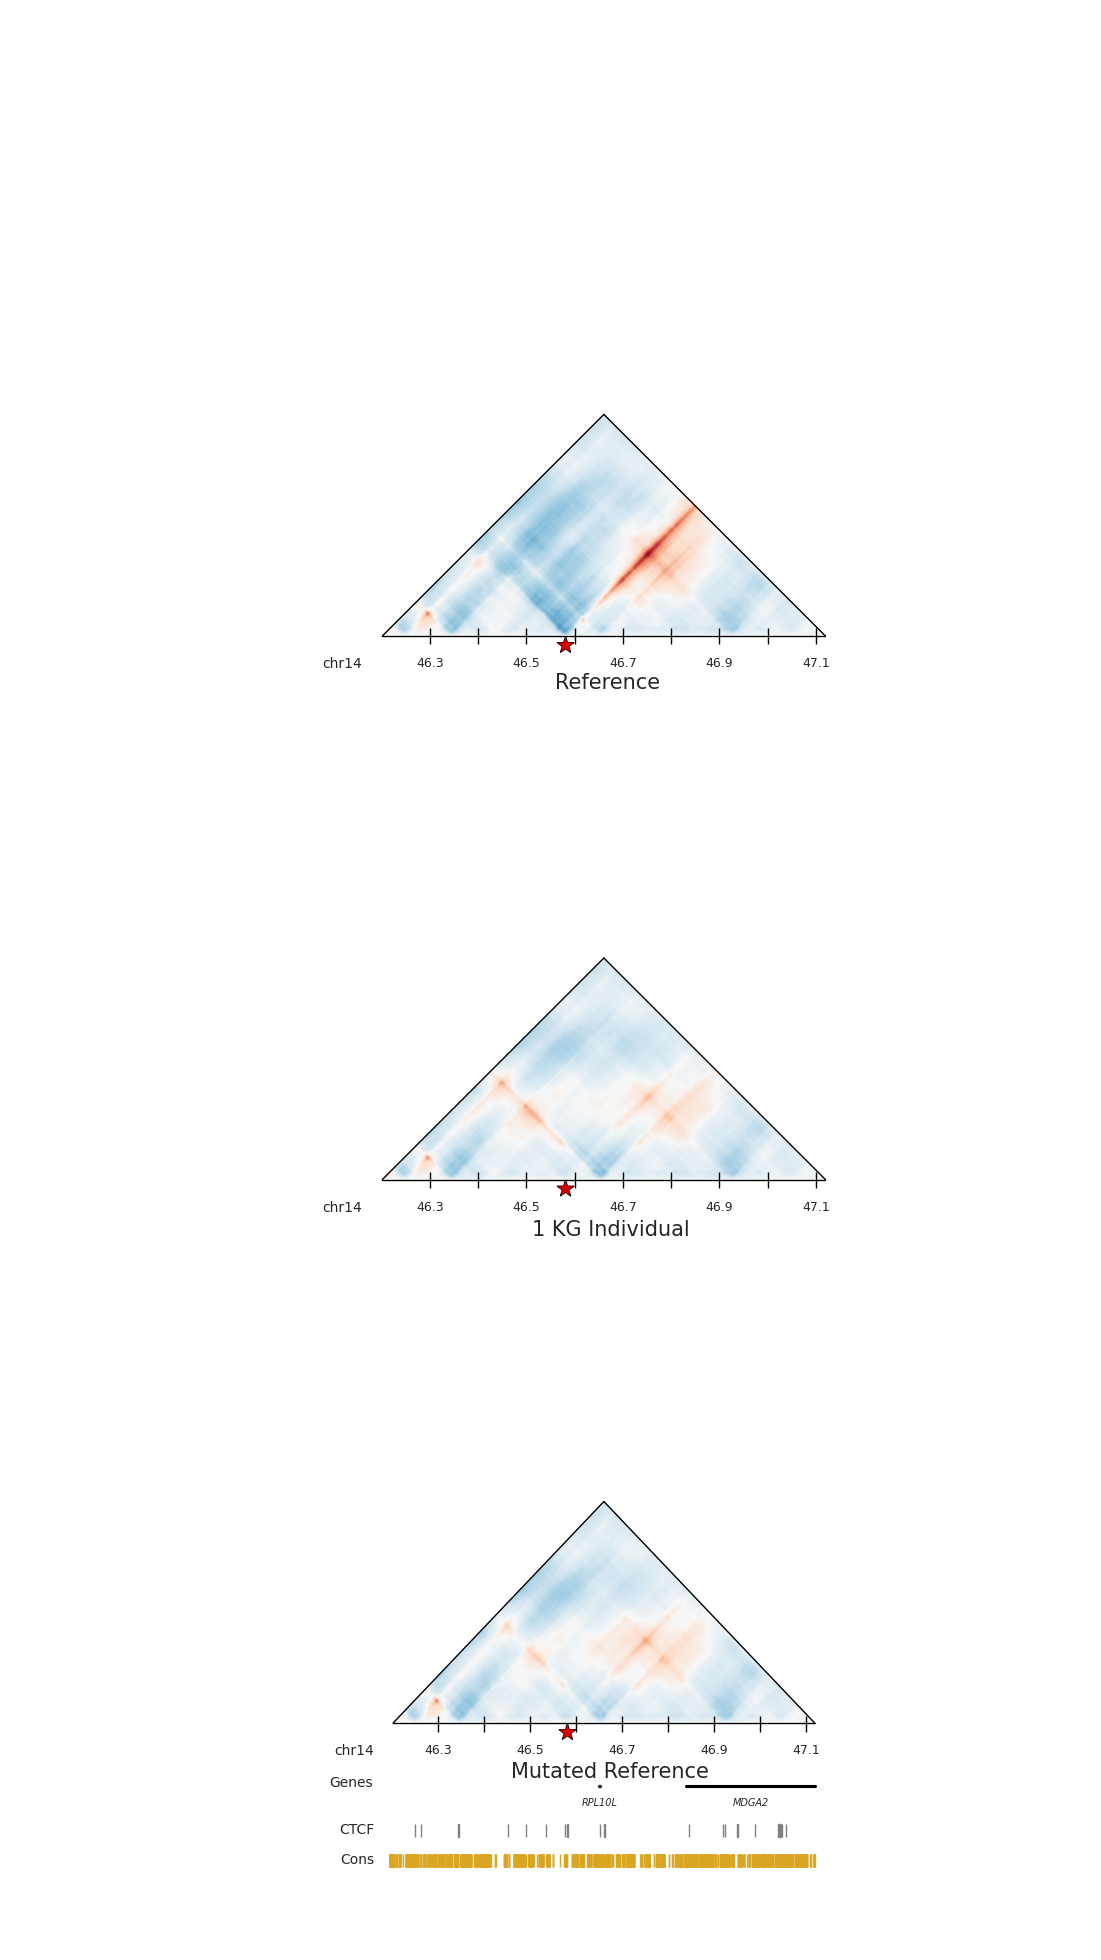

In [30]:
map_comparison_IDW_prediction(ref_pred, idw_pred, mut_pred_hff, chrm, wndw, variant_pos)

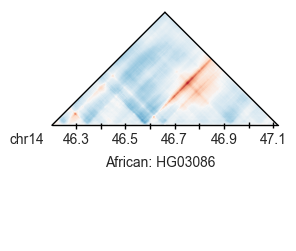

In [33]:
common_ind = 'AFR_MSL_female_HG03086'

#common_pred = load_1kg_map(chrm, wndw, common_ind)
_ = visualize_map(common_pred, wndw, 'African: %s' % common_ind.split('_')[-1], chrm, 448, sat=.6)

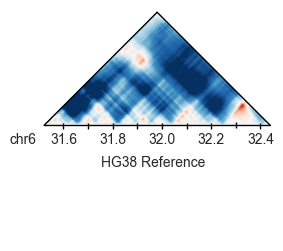

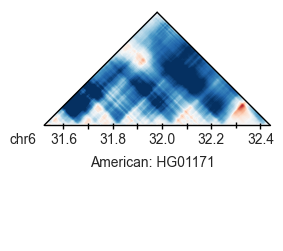

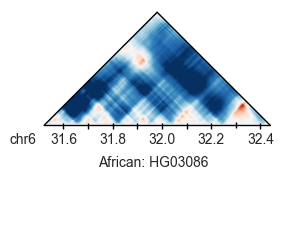

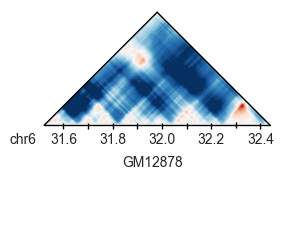

1049
(array([  0,   0,   0, ..., 914, 914, 915]), array([  2,   3,   4, ..., 916, 917, 917]))
(918, 918)
(419986,)


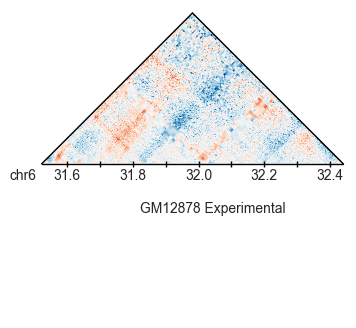

In [213]:
chr = 'chr6'
window_start = 31457280
idw_ind = 'AMR_PUR_female_HG01171'
common_ind = 'AFR_MSL_female_HG03086'

ref_pred = load_1kg_map(chr, window_start, 'hg38_reference')
idw_pred  = load_1kg_map(chr, window_start, idw_ind)
common_pred = load_1kg_map(chr, window_start, common_ind)
exp_pred = load_1kg_map(chr, window_start, 'EUR_CEU_female_NA12878')
_ = visualize_map(ref_pred, window_start, 'HG38 Reference', chr, 448, sat=1)
_ = visualize_map(idw_pred, window_start, 'American: %s' % idw_ind.split('_')[-1], chr, 448, sat=1)
_ = visualize_map(common_pred, window_start, 'African: %s' % common_ind.split('_')[-1], chr, 448, sat=1)
_ = visualize_map(exp_pred, window_start, 'GM12878', chr, 448, sat=1)

target = get_target(chr,window_start,window_start + 2**20,genome_hic_cool, 1000)
mat = visualize_map_exp(target, window_start,chr, 918, sat=2)



## example divergent windows

In [25]:
chr = 'chr7'
window_start = 125829120
variant_pos = 126645389
alt_allele = 'T'

anc_seq = get_anc_seq(chr, window_start)
alt_seq = get_alt_seq(chr, window_start, variant_pos, alt_allele, base='anc')

anc_pred = runAkitaPreds(anc_seq)
anc_pred_hff = anc_pred[:,:,0][0]

alt_pred = runAkitaPreds(alt_seq)
alt_pred_hff = alt_pred[:,:,0][0]


maxi = "_".join(list(anc_div.loc[chr].loc[window_start].idxmax()))

ind_pred = load_1kg_map(chr, window_start, maxi)

mse, divergence = comparePreds(anc_pred_hff, alt_pred_hff)
print(divergence)



1/1 [==============================] - 1s 805ms/step
0.22220409433507415


In [26]:
maxi

'AFR_LWK_female_NA19327'

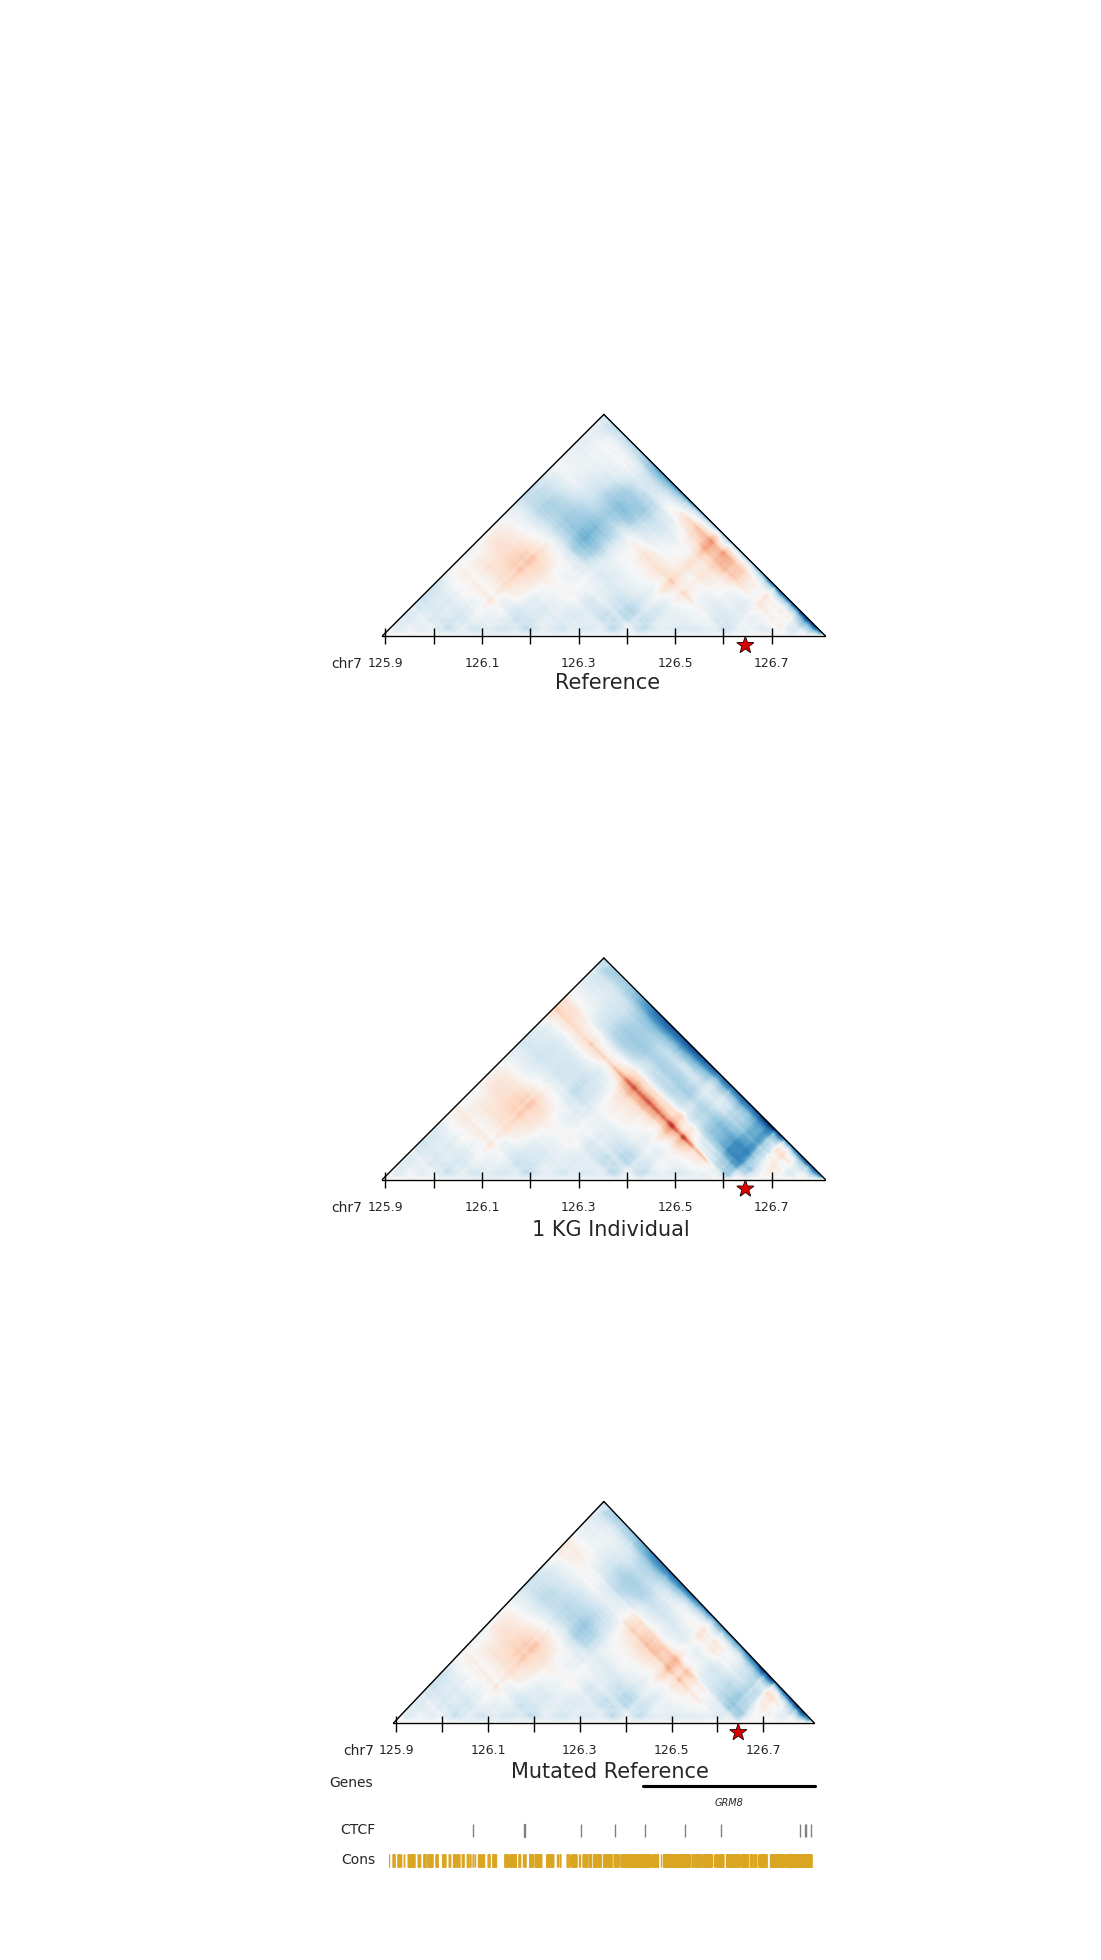

In [27]:
map_comparison_IDW_prediction(anc_pred_hff, ind_pred, alt_pred_hff, chr, window_start, variant_pos)

1/1 [==============================] - 2s 2s/step
0.1818410270166012


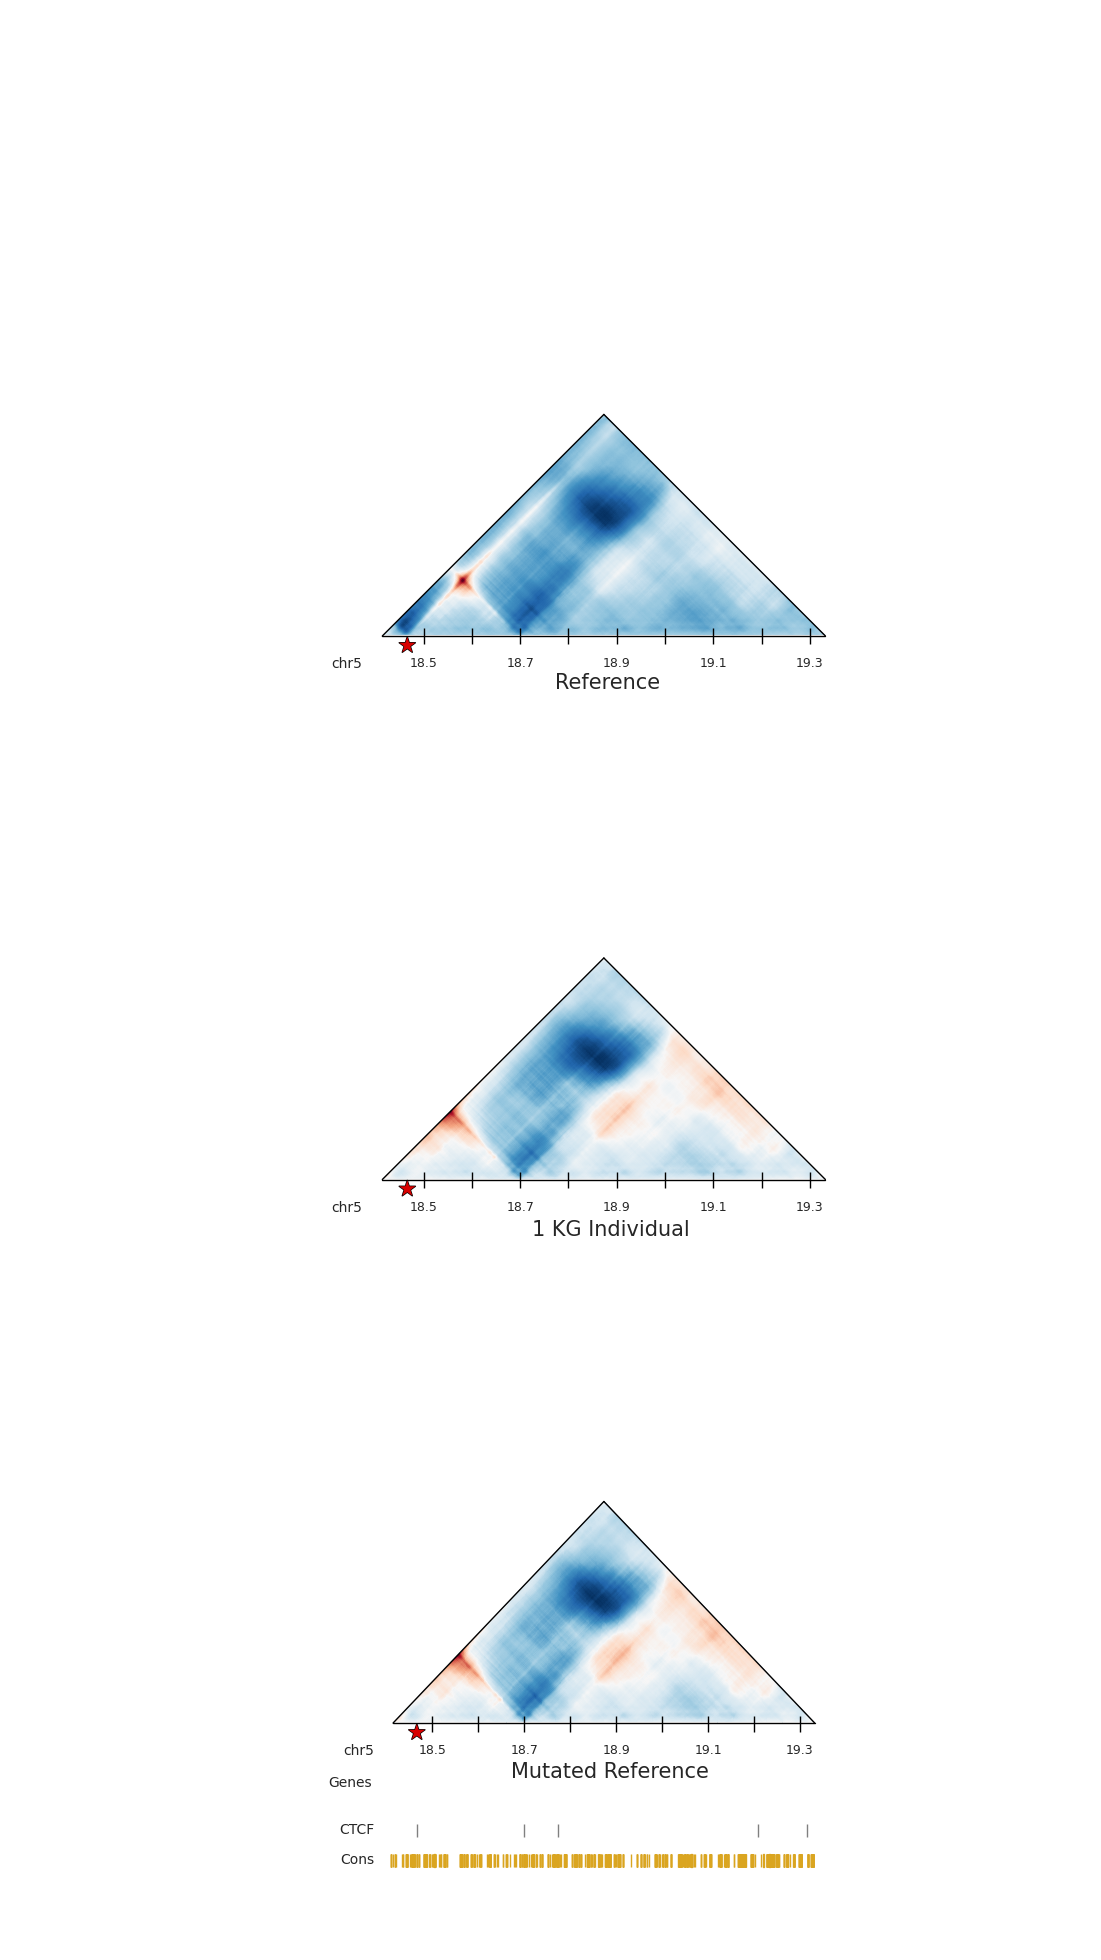

In [333]:
chr = 'chr5'
window_start = 18350080
variant_pos = 18466287
alt_allele = 'A'

anc_seq = get_anc_seq(chr, window_start)
alt_seq = get_alt_seq(chr, window_start, variant_pos, alt_allele, base='anc')

anc_pred = runAkitaPreds(anc_seq)
anc_pred_hff = anc_pred[:,:,0][0]

alt_pred = runAkitaPreds(alt_seq)
alt_pred_hff = alt_pred[:,:,0][0]

maxi = "_".join(list(anc_div.loc[chr].loc[window_start].idxmax()))
mani = "_".join(list(anc_div.loc[chr].loc[window_start].idxmin()))
ind_pred = load_1kg_map(chr, window_start, maxi)

mse, divergence = comparePreds(anc_pred_hff, alt_pred_hff)
print(divergence)
map_comparison_IDW_prediction(anc_pred_hff, ind_pred, alt_pred_hff, chr, window_start, variant_pos)

In [278]:
print(maxi)
anc_div.loc[chr].loc[window_start].max()

AMR_PUR_female_HG01171


0.20193398387806283

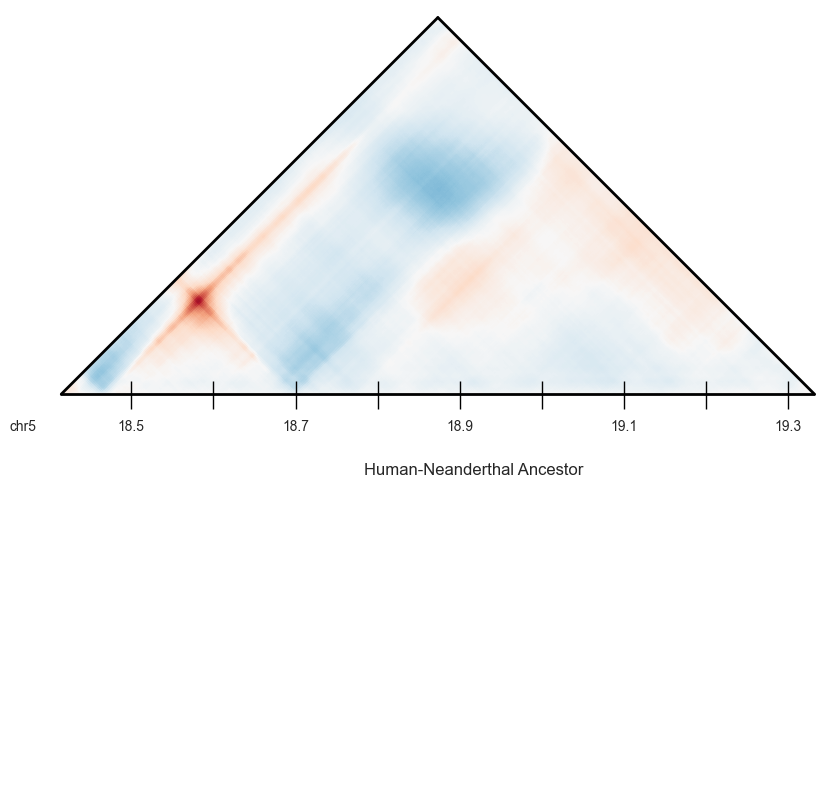

In [332]:
_ = visualize_map(anc_pred_hff, window_start, 'Human-Neanderthal Ancestor', chr, 448)

In [279]:
print(mani)
anc_div.loc[chr].loc[window_start].min()

SAS_PJL_male_HG02654


0.00454556411018503

In [335]:
mani

'SAS_PJL_male_HG02654'

masked_array(
  data=[[nan, --, --, ..., --, --, --],
        [nan, nan, --, ..., --, --, --],
        [0.08701858, nan, nan, ..., --, --, --],
        ...,
        [-0.042306602, -0.035325646, -0.038203, ..., nan, --, --],
        [-0.048191845, -0.03969282, -0.041981697, ..., nan, nan, --],
        [-0.058552653, -0.04829344, -0.043662608, ..., -0.011879176, nan,
         nan]],
  mask=[[False,  True,  True, ...,  True,  True,  True],
        [False, False,  True, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        ...,
        [False, False, False, ..., False,  True,  True],
        [False, False, False, ..., False, False,  True],
        [False, False, False, ..., False, False, False]],
  fill_value=1e+20)

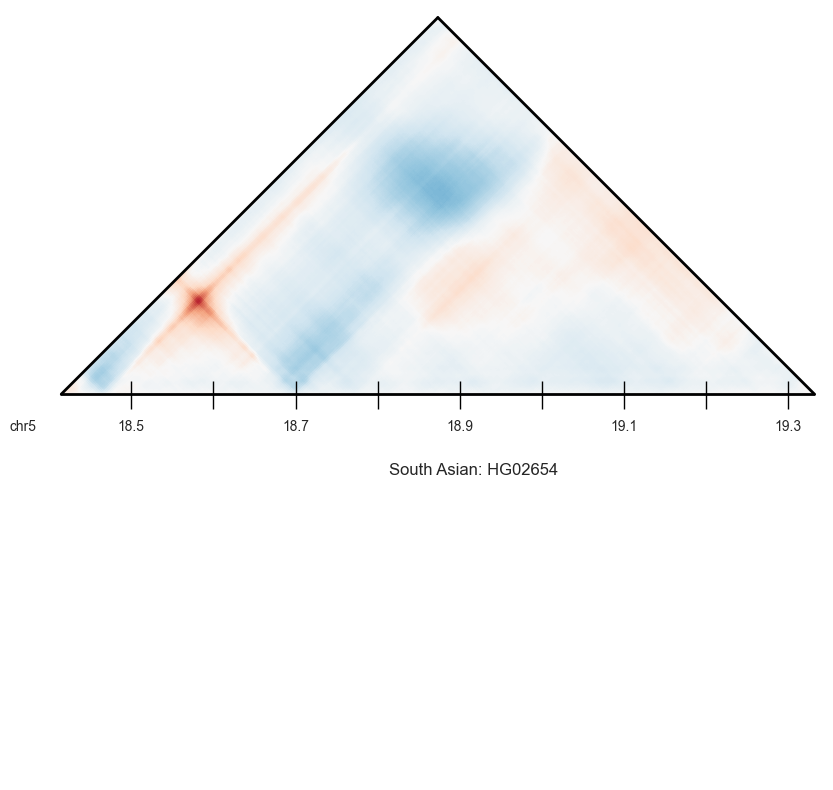

In [338]:

ind_pred = load_1kg_map(chr, window_start, mani)
visualize_map(ind_pred, window_start, 'South Asian: %s' % mani.split('_')[-1], chr, 448)


In [276]:
maxi

'AMR_PUR_female_HG01171'

masked_array(
  data=[[nan, --, --, ..., --, --, --],
        [nan, nan, --, ..., --, --, --],
        [0.06984684, nan, nan, ..., --, --, --],
        ...,
        [0.0016980171, -0.0028606951, -0.014765918, ..., nan, --, --],
        [0.0075815916, 0.0009159446, -0.011157811, ..., nan, nan, --],
        [0.014628023, 0.007992774, -0.003735453, ..., -0.011502653, nan,
         nan]],
  mask=[[False,  True,  True, ...,  True,  True,  True],
        [False, False,  True, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        ...,
        [False, False, False, ..., False,  True,  True],
        [False, False, False, ..., False, False,  True],
        [False, False, False, ..., False, False, False]],
  fill_value=1e+20)

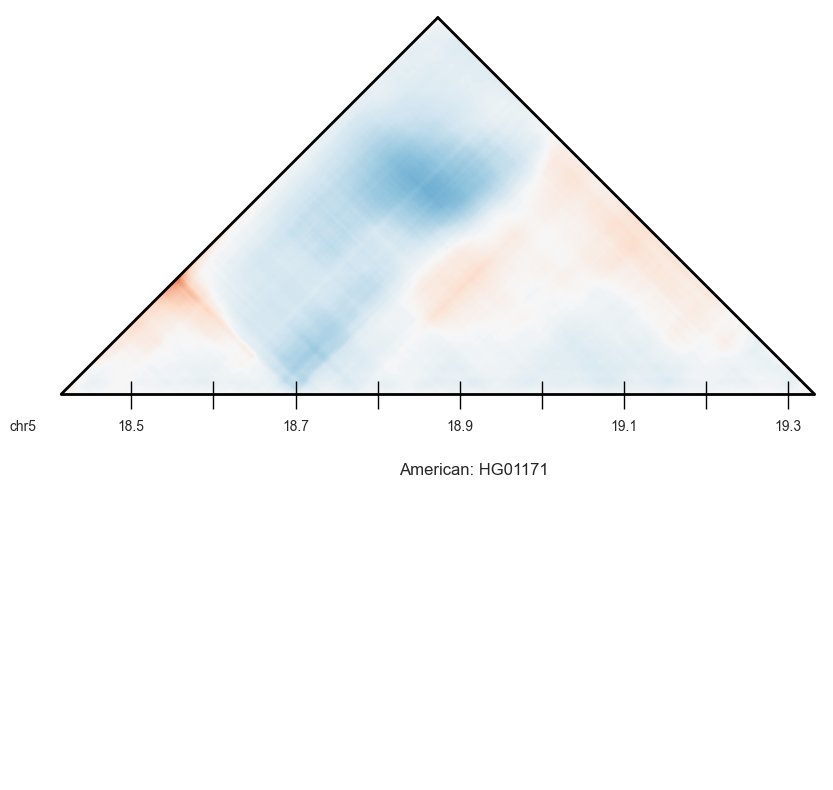

In [339]:
ind_pred = load_1kg_map(chr, window_start, maxi)
visualize_map(ind_pred, window_start, 'American: %s' % maxi.split('_')[-1], chr, 448)

masked_array(
  data=[[nan, --, --, ..., --, --, --],
        [nan, nan, --, ..., --, --, --],
        [0.07627484202384949, nan, nan, ..., --, --, --],
        ...,
        [0.002126723527908325, -0.0017619431018829346,
         -0.013018697500228882, ..., nan, --, --],
        [0.007962554693222046, 0.0019191205501556396,
         -0.009716540575027466, ..., nan, nan, --],
        [0.012033075094223022, 0.006359130144119263,
         -0.0023929178714752197, ..., -0.012016534805297852, nan, nan]],
  mask=[[False,  True,  True, ...,  True,  True,  True],
        [False, False,  True, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        ...,
        [False, False, False, ..., False,  True,  True],
        [False, False, False, ..., False, False,  True],
        [False, False, False, ..., False, False, False]],
  fill_value=1e+20)

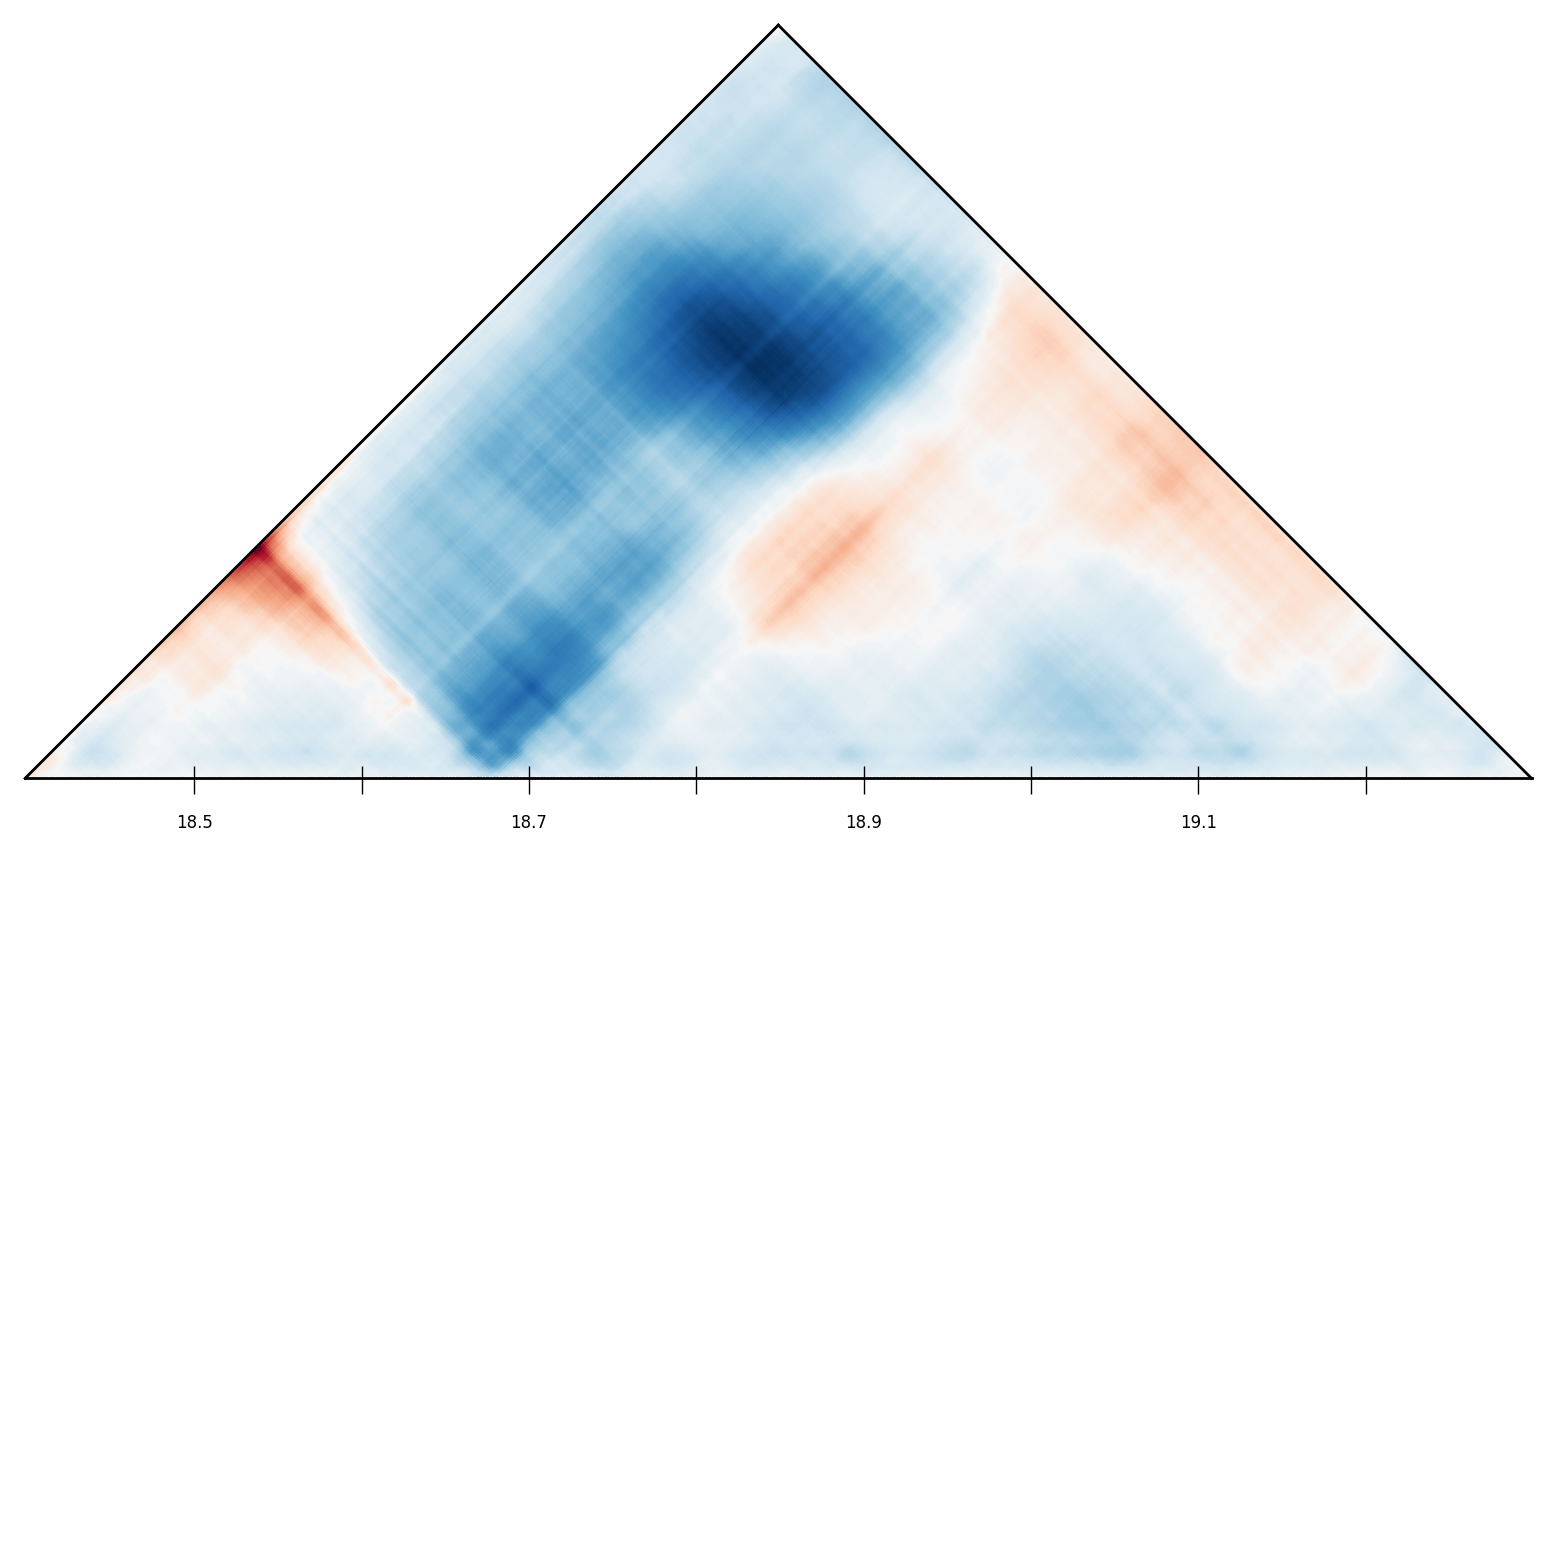

In [252]:
mut_name = 'hsmrca_mut%s' % variant_pos
visualize_map(alt_pref_hff, window_start, mut_name, chr, 448)


## Experimental

### GM12878 in divergent windows

In [177]:
genome_hic_cool = cooler.Cooler('/wynton/group/capra/data/wynton_databases/4DN/GM12878/4DNFIXP4QG5B.mcool::resolutions/1000')




1050


/wynton/home/capra/egilbertson/.conda/envs/modern3d/lib/python3.9/site-packages/cooltools/lib/numutils.py:1376: RuntimeWarning: invalid value encountered in divide
  val_cur = ar_cur / armask_cur


(array([  0,   0,   0, ..., 914, 914, 915]), array([  2,   3,   4, ..., 916, 917, 917]))
(918, 918)
(419986,)
1/1 [==============================] - 1s 565ms/step


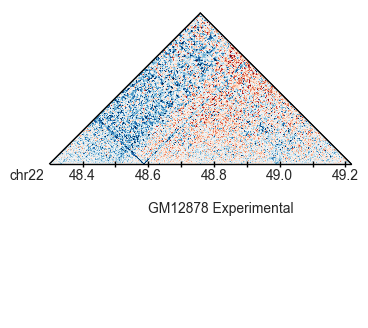

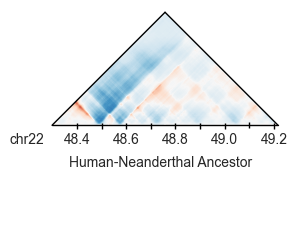

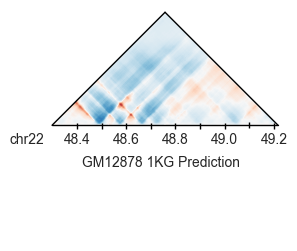

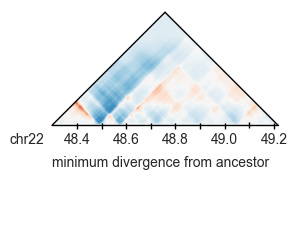

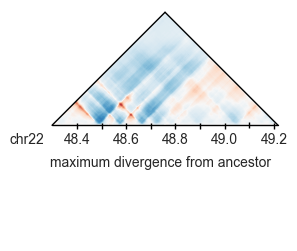

In [196]:
chrm = 'chr22'
wndw =  48234496
exp_more_div_window_comp(chrm, wndw, hic_res=1000, exp_map_dim=918)

1050


/wynton/home/capra/egilbertson/.conda/envs/modern3d/lib/python3.9/site-packages/cooltools/lib/numutils.py:1376: RuntimeWarning: invalid value encountered in divide
  val_cur = ar_cur / armask_cur


(array([  0,   0,   0, ..., 914, 914, 915]), array([  2,   3,   4, ..., 916, 917, 917]))
(918, 918)
(419986,)
1/1 [==============================] - 1s 554ms/step


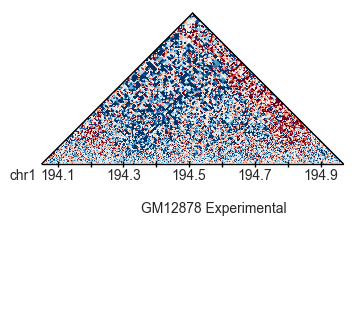

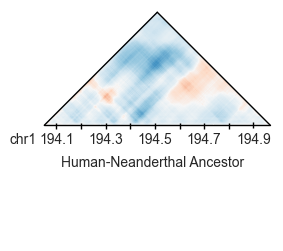

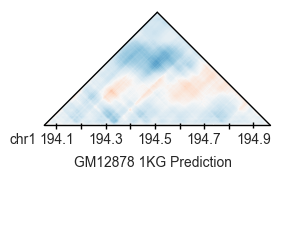

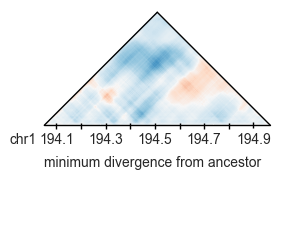

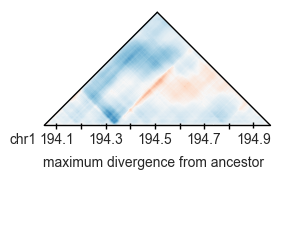

In [199]:
chrm = 'chr1'
wndw = 193986560
exp_more_div_window_comp(chrm, wndw, hic_res=1000, exp_map_dim=918, sat=0.5)

1049


/wynton/home/capra/egilbertson/.conda/envs/modern3d/lib/python3.9/site-packages/cooltools/lib/numutils.py:1376: RuntimeWarning: invalid value encountered in divide
  val_cur = ar_cur / armask_cur


(array([  0,   0,   0, ..., 914, 914, 915]), array([  2,   3,   4, ..., 916, 917, 917]))
(918, 918)
(419986,)
1/1 [==============================] - 1s 547ms/step


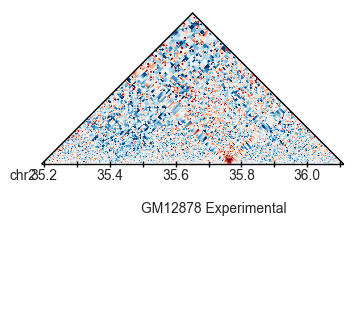

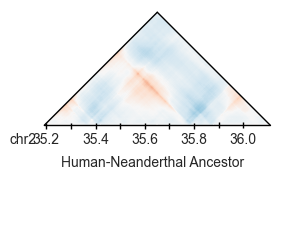

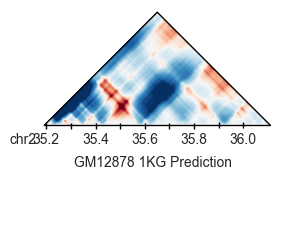

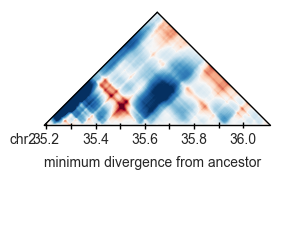

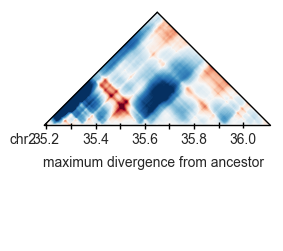

In [200]:
chrm = 'chr2'
wndw = 35127296
exp_more_div_window_comp(chrm, wndw, hic_res=1000, exp_map_dim=918)

1050


/wynton/home/capra/egilbertson/.conda/envs/modern3d/lib/python3.9/site-packages/cooltools/lib/numutils.py:1376: RuntimeWarning: invalid value encountered in divide
  val_cur = ar_cur / armask_cur


(array([  0,   0,   0, ..., 914, 914, 915]), array([  2,   3,   4, ..., 916, 917, 917]))
(918, 918)
(419986,)
1/1 [==============================] - 1s 574ms/step


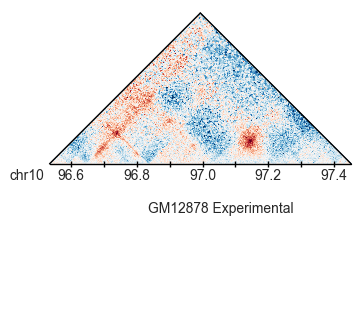

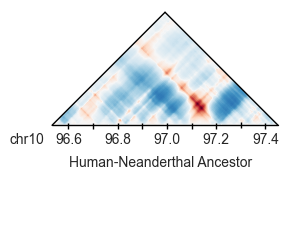

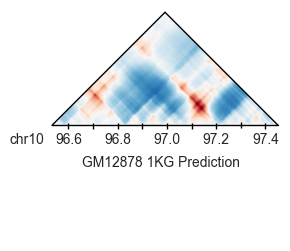

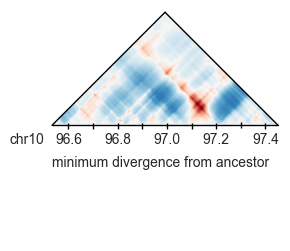

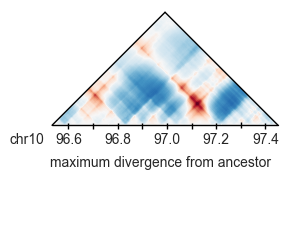

In [203]:
chrm = 'chr10'
wndw = 96468992
exp_more_div_window_comp(chrm, wndw, hic_res=1000, exp_map_dim=918, sat=1.5)

1050


/wynton/home/capra/egilbertson/.conda/envs/modern3d/lib/python3.9/site-packages/cooltools/lib/numutils.py:1376: RuntimeWarning: invalid value encountered in divide
  val_cur = ar_cur / armask_cur


(array([  0,   0,   0, ..., 914, 914, 915]), array([  2,   3,   4, ..., 916, 917, 917]))
(918, 918)
(419986,)
1/1 [==============================] - 1s 582ms/step


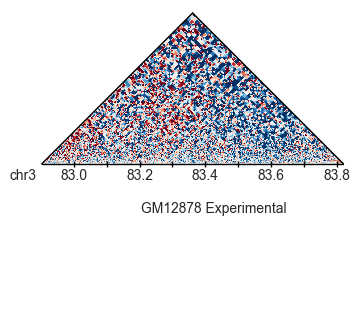

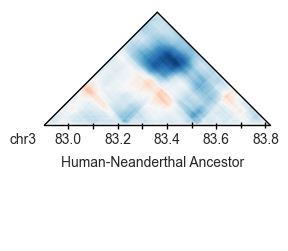

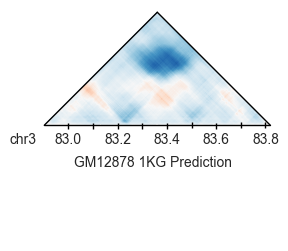

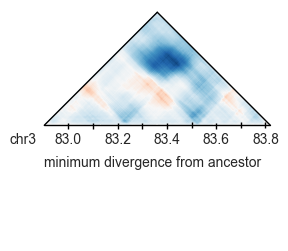

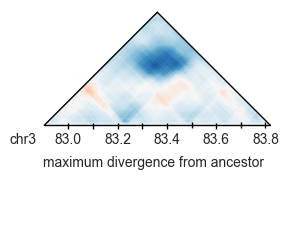

In [205]:
chrm = 'chr3'
wndw = 82837504
exp_more_div_window_comp(chrm, wndw, hic_res=1000, exp_map_dim=918, sat=.5)

1049


/wynton/home/capra/egilbertson/.conda/envs/modern3d/lib/python3.9/site-packages/cooltools/lib/numutils.py:1376: RuntimeWarning: invalid value encountered in divide
  val_cur = ar_cur / armask_cur


(array([  0,   0,   0, ..., 914, 914, 915]), array([  2,   3,   4, ..., 916, 917, 917]))
(918, 918)
(419986,)
1/1 [==============================] - 1s 552ms/step


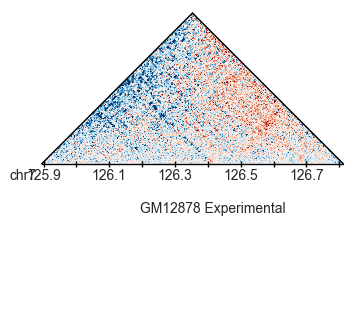

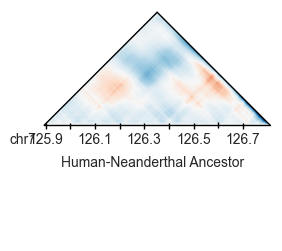

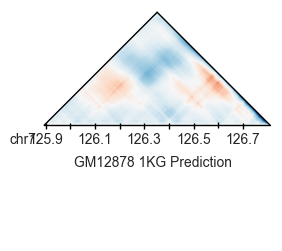

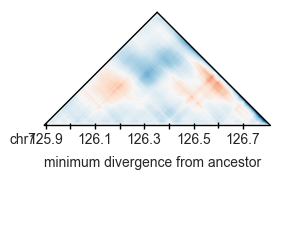

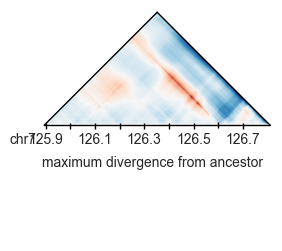

In [187]:
chrm = 'chr7'
wndw = 125829120
exp_more_div_window_comp(chrm, wndw, hic_res=1000, exp_map_dim=918)


1049


/wynton/home/capra/egilbertson/.conda/envs/modern3d/lib/python3.9/site-packages/cooltools/lib/numutils.py:1376: RuntimeWarning: invalid value encountered in divide
  val_cur = ar_cur / armask_cur


(array([  0,   0,   0, ..., 914, 914, 915]), array([  2,   3,   4, ..., 916, 917, 917]))
(918, 918)
(419986,)
1/1 [==============================] - 1s 558ms/step


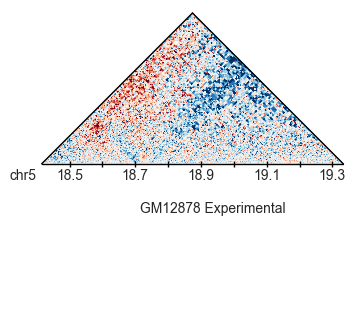

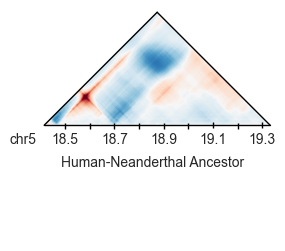

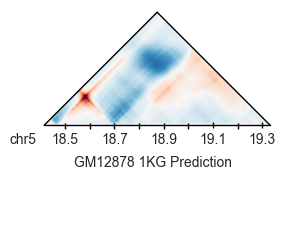

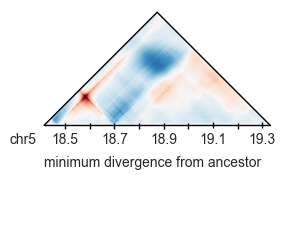

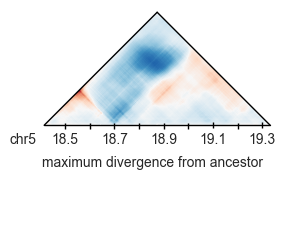

In [188]:
chrm = 'chr5'
wndw = 18350080
exp_more_div_window_comp(chrm, wndw, hic_res=1000, exp_map_dim=918)

### testing

106
(array([ 0,  0,  0, ..., 88, 88, 89]), array([ 2,  3,  4, ..., 90, 91, 91]))
(92, 92)
(4095,)


/wynton/home/capra/egilbertson/.conda/envs/modern3d/lib/python3.9/site-packages/cooltools/lib/numutils.py:1376: RuntimeWarning: invalid value encountered in divide
  val_cur = ar_cur / armask_cur


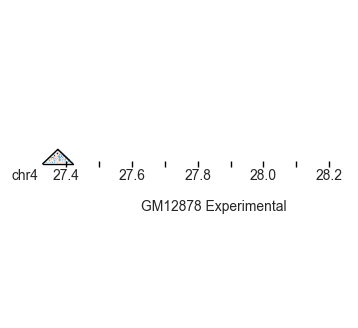

In [104]:
genome_hic_cool = cooler.Cooler('/wynton/group/capra/projects/modern_human_3Dgenome/data/experimental/HG00514/preprocessed/4DNFIEWJXIW4.mcool::resolutions/10000')

chrm = 'chr4'
wndw = 27262976

target = get_target(chrm,wndw,wndw + 2**20,genome_hic_cool, 10000)

mat = visualize_map_exp(target, wndw,chrm, 92)

In [217]:
target.shape

(16471,)

In [208]:
seq_len_hic

16471

# 4DN 1KG maps

In [54]:
genome_hic_cool = cooler.Cooler('/wynton/group/capra/projects/modern_human_3Dgenome/data/experimental/4DN_preprocessed/4DNFIL76YMY6.mcool::resolutions/5000')


In [206]:
genome_hic_cool

<Cooler "4DNFIEWJXIW4.mcool::/resolutions/5000">

In [203]:
target.shape

(99681,)

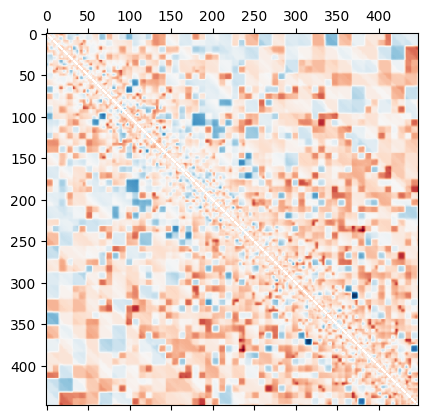

In [204]:
mat = from_upper_triu(target, 448, 2)
#mask =  np.tri(mat.shape[0], k = -1) # bottom-half
#mat = np.ma.array(mat, mask = mask).T # transpose
plt.matshow(mat, cmap = 'RdBu_r')

106
(array([ 0,  0,  0, ..., 88, 88, 89]), array([ 2,  3,  4, ..., 90, 91, 91]))
(92, 92)
(4095,)


/wynton/home/capra/egilbertson/.conda/envs/modern3d/lib/python3.9/site-packages/cooltools/lib/numutils.py:1376: RuntimeWarning: invalid value encountered in divide
  val_cur = ar_cur / armask_cur


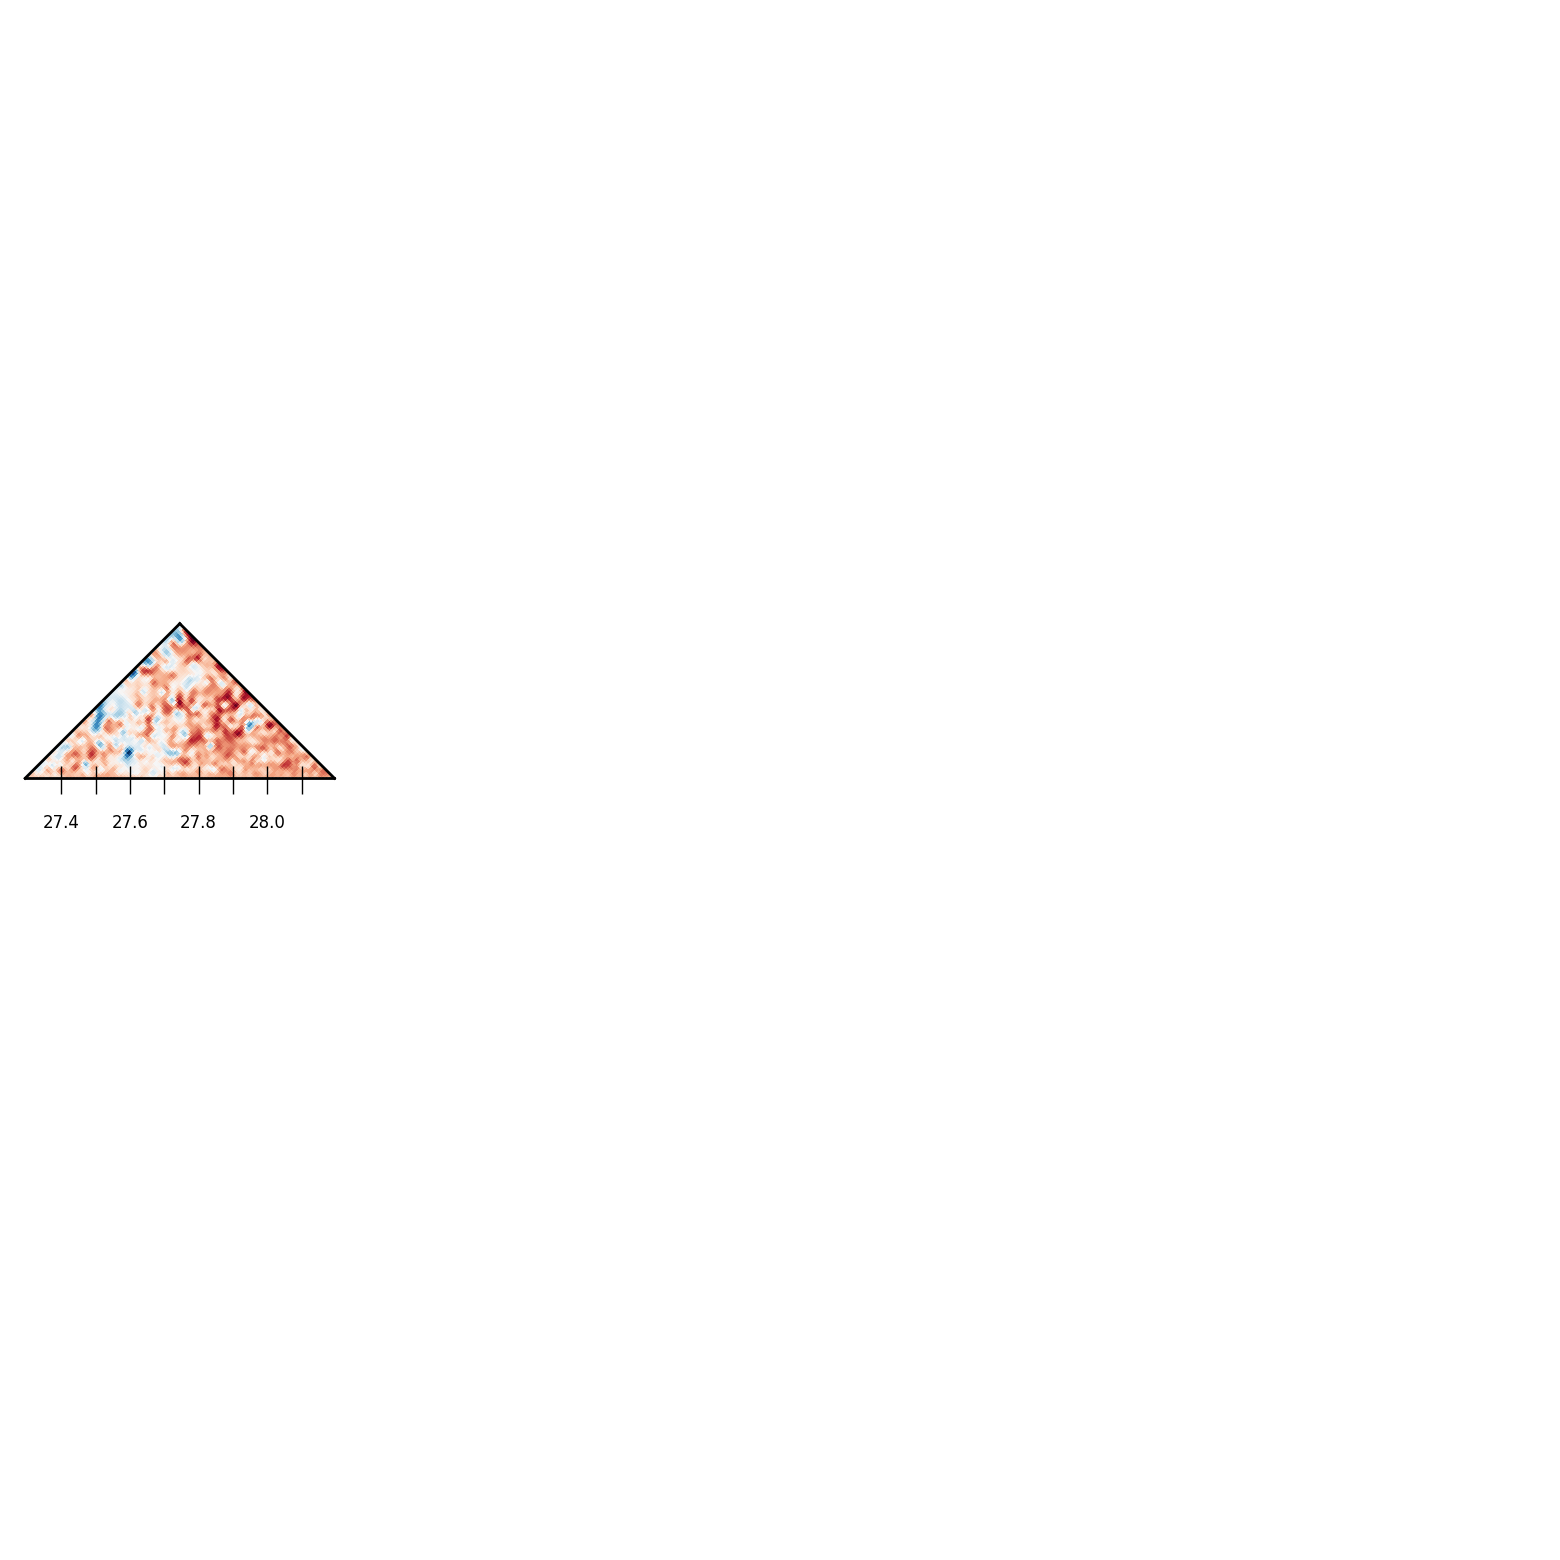

In [223]:
genome_hic_cool = cooler.Cooler('/wynton/group/capra/projects/modern_human_3Dgenome/data/experimental/HG00864_1000.mcool::resolutions/10000')

chrm = 'chr4'
wndw = 27262976
individual = 'EAS_CDX_female_HG00864'

target = get_target(chrm,wndw,wndw + 2**20,genome_hic_cool, 10000)

mat = visualize_map(target, wndw, 92)

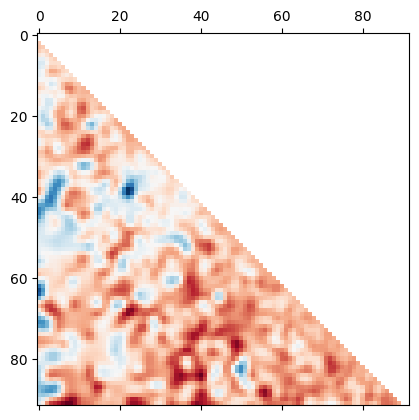

In [225]:
mat = from_upper_triu(target, 92, 2)
mask =  np.tri(mat.shape[0], k = -1) # bottom-half
mat = np.ma.array(mat, mask = mask).T # transpose
plt.matshow(mat, cmap = 'RdBu_r')

525
(array([  0,   0,   0, ..., 444, 444, 445]), array([  2,   3,   4, ..., 446, 447, 447]))
(448, 448)
(99681,)


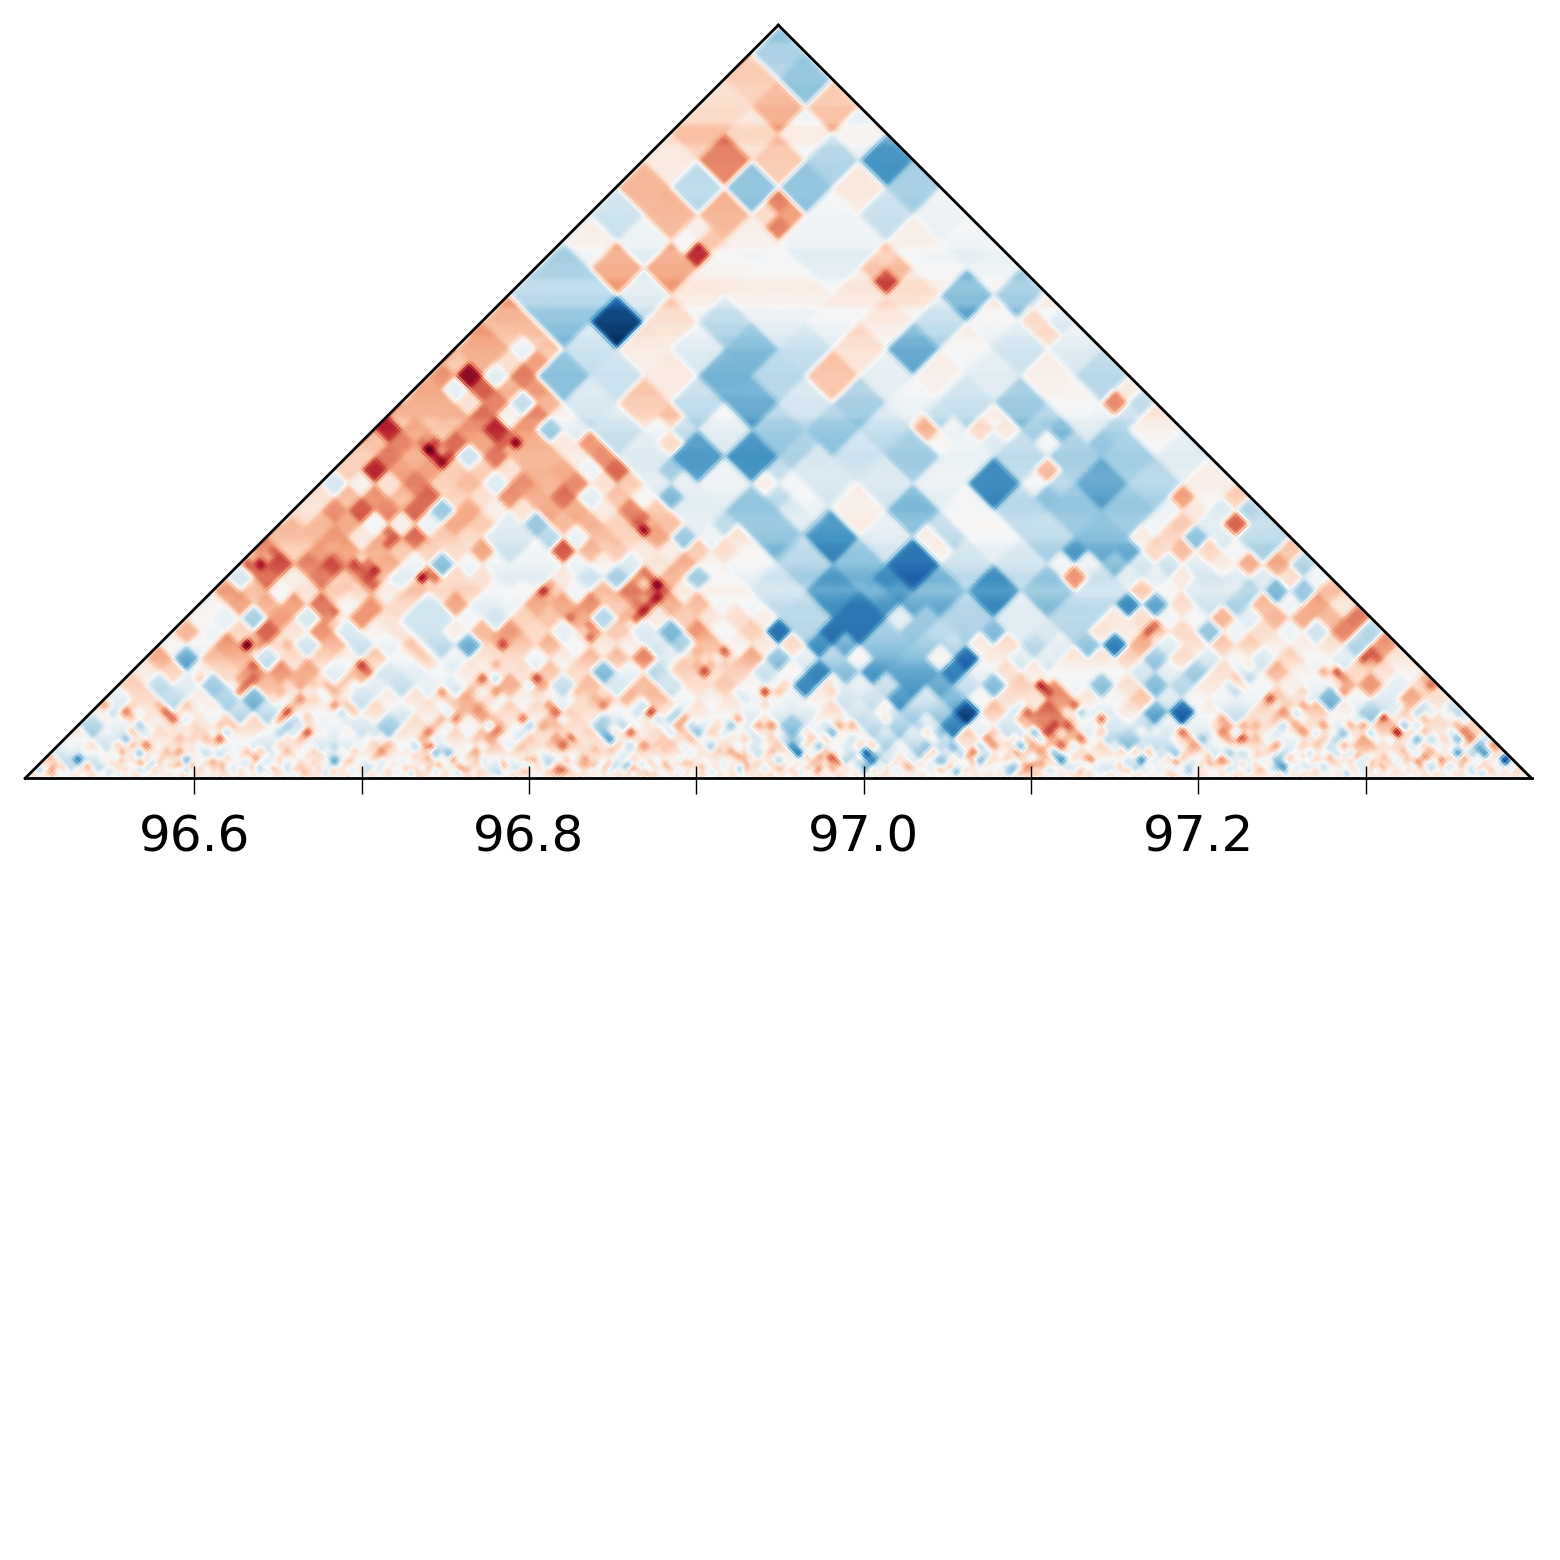

In [102]:
ind1_mat = from_upper_triu(pred, 448, 2)
    mask =  np.tri(ind1_mat.shape[0], k = -1) # bottom-half
    ind1_mat = np.ma.array(ind1_mat, mask = mask).T # transposechrm = 'chr7'
wndw = 96468992
individual = 'EAS_CDX_female_HG00864'

target = get_target(chrm,wndw,wndw + 2**20,genome_hic_cool)
visualize_map(target, wndw)

525
(array([  0,   0,   0, ..., 444, 444, 445]), array([  2,   3,   4, ..., 446, 447, 447]))
(448, 448)
(99681,)


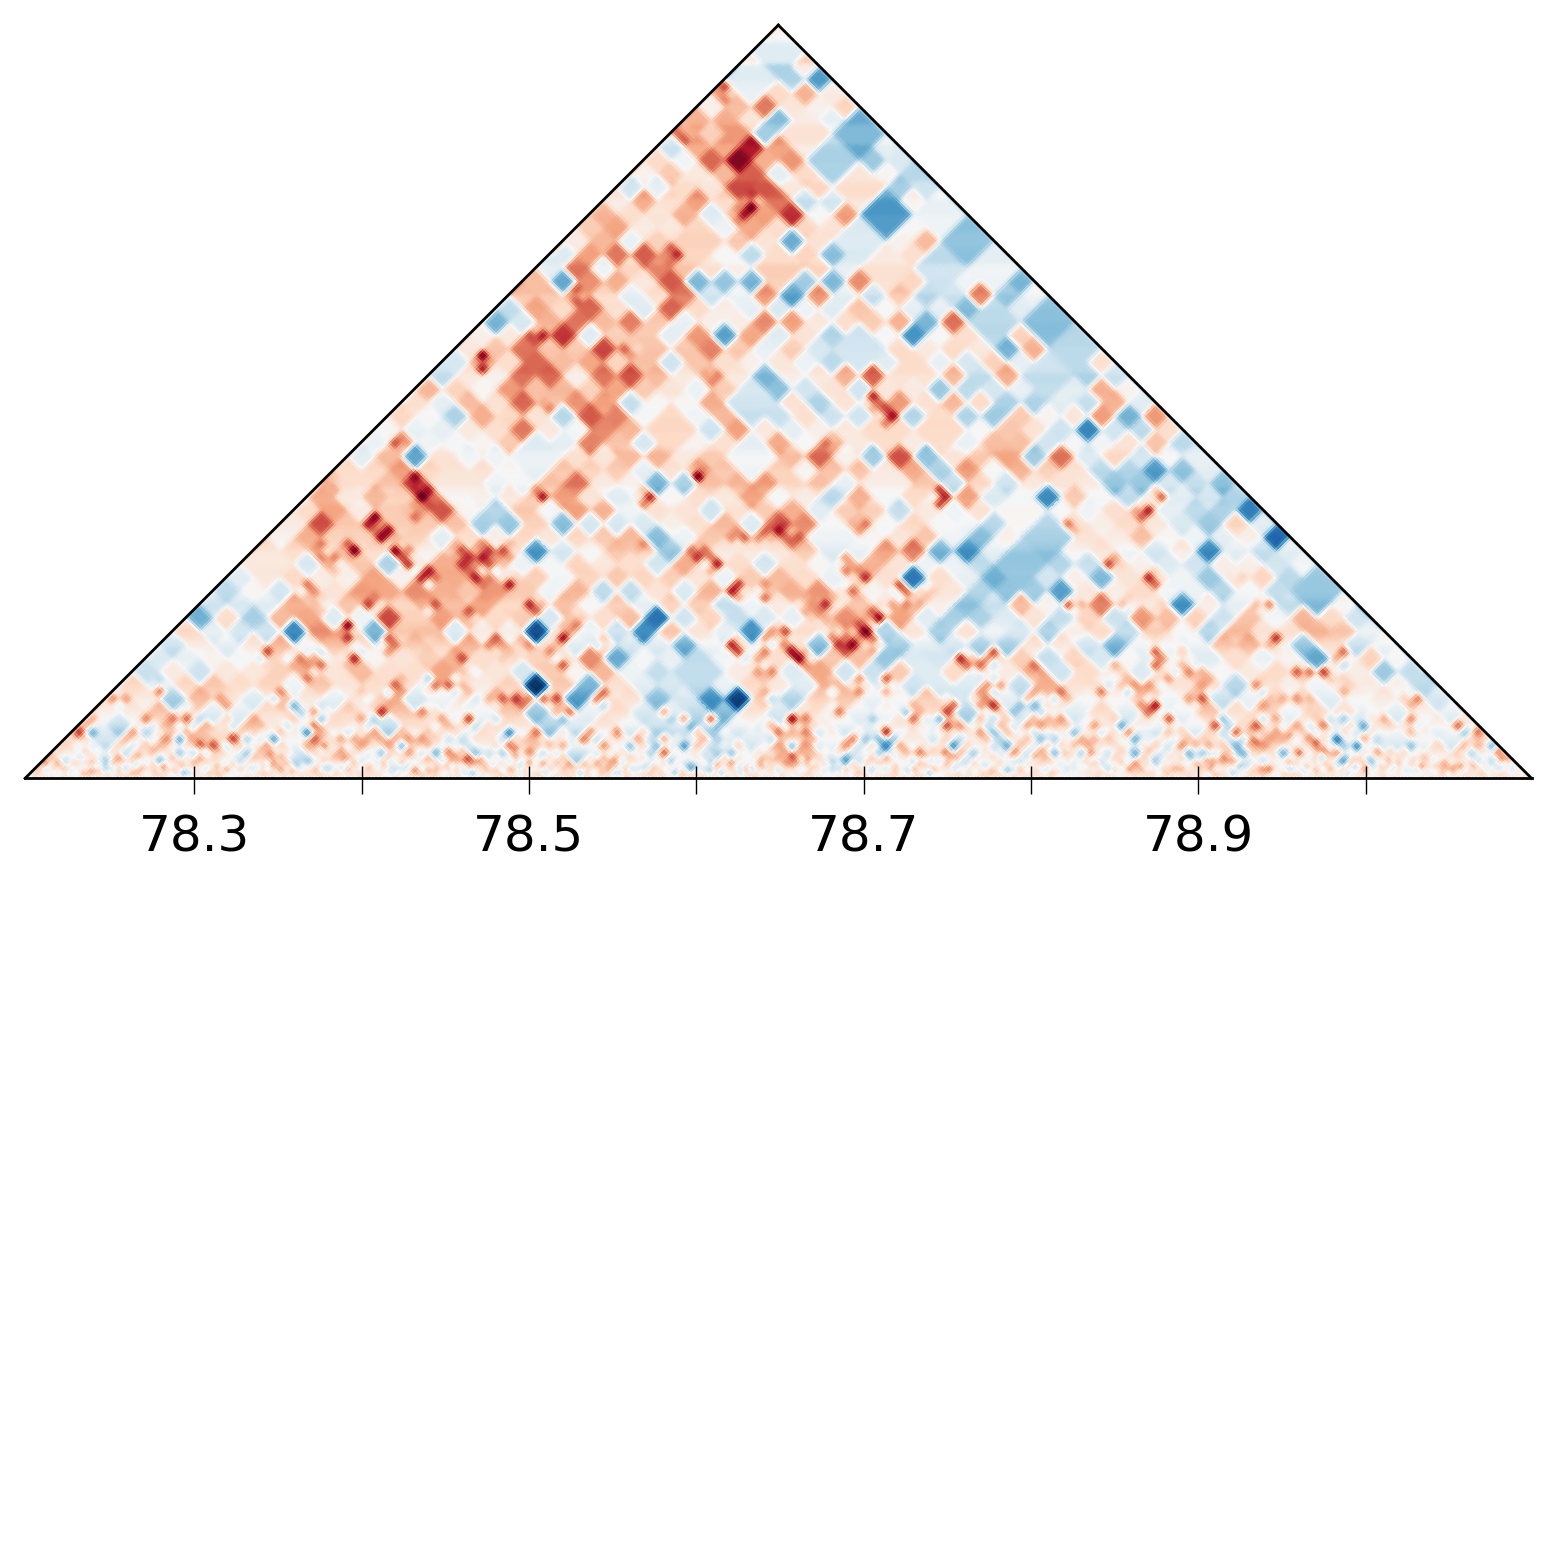

In [103]:
chrm = 'chr13'
wndw = 78118912
individual = 'EAS_CDX_female_HG00864'
target = get_target(chrm,wndw,wndw + 2**20,genome_hic_cool)
visualize_map(target, wndw)

In [58]:
ind1_mat = from_upper_triu(target, 448, 2)

In [69]:
ind1_mat

array([[        nan,         nan, -0.07348633, ..., -0.38696289,
        -0.37231445, -0.30615234],
       [        nan,         nan,         nan, ..., -0.515625  ,
        -0.49194336, -0.3840332 ],
       [-0.07348633,         nan,         nan, ..., -0.54101562,
        -0.51806641, -0.40136719],
       ...,
       [-0.38696289, -0.515625  , -0.54101562, ...,         nan,
                nan, -0.08093262],
       [-0.37231445, -0.49194336, -0.51806641, ...,         nan,
                nan,         nan],
       [-0.30615234, -0.3840332 , -0.40136719, ..., -0.08093262,
                nan,         nan]])

In [63]:
target.shape

(99681,)

In [66]:
target[np.isnan(target)]

array([], dtype=float16)

In [67]:
np.isnan(target)

array([False, False, False, ..., False, False, False])

In [68]:
target

array([-0.0735 , -0.3044 , -0.676  , ..., -0.171  , -0.18   , -0.08093],
      dtype=float16)

In [35]:
92/2

46.0

211
(array([  0,   0,   0, ..., 179, 179, 180]), array([  2,   3,   4, ..., 181, 182, 182]))
(183, 183)
(16471,)


/wynton/home/capra/egilbertson/.conda/envs/modern3d/lib/python3.9/site-packages/cooltools/lib/numutils.py:1376: RuntimeWarning: invalid value encountered in divide
  val_cur = ar_cur / armask_cur


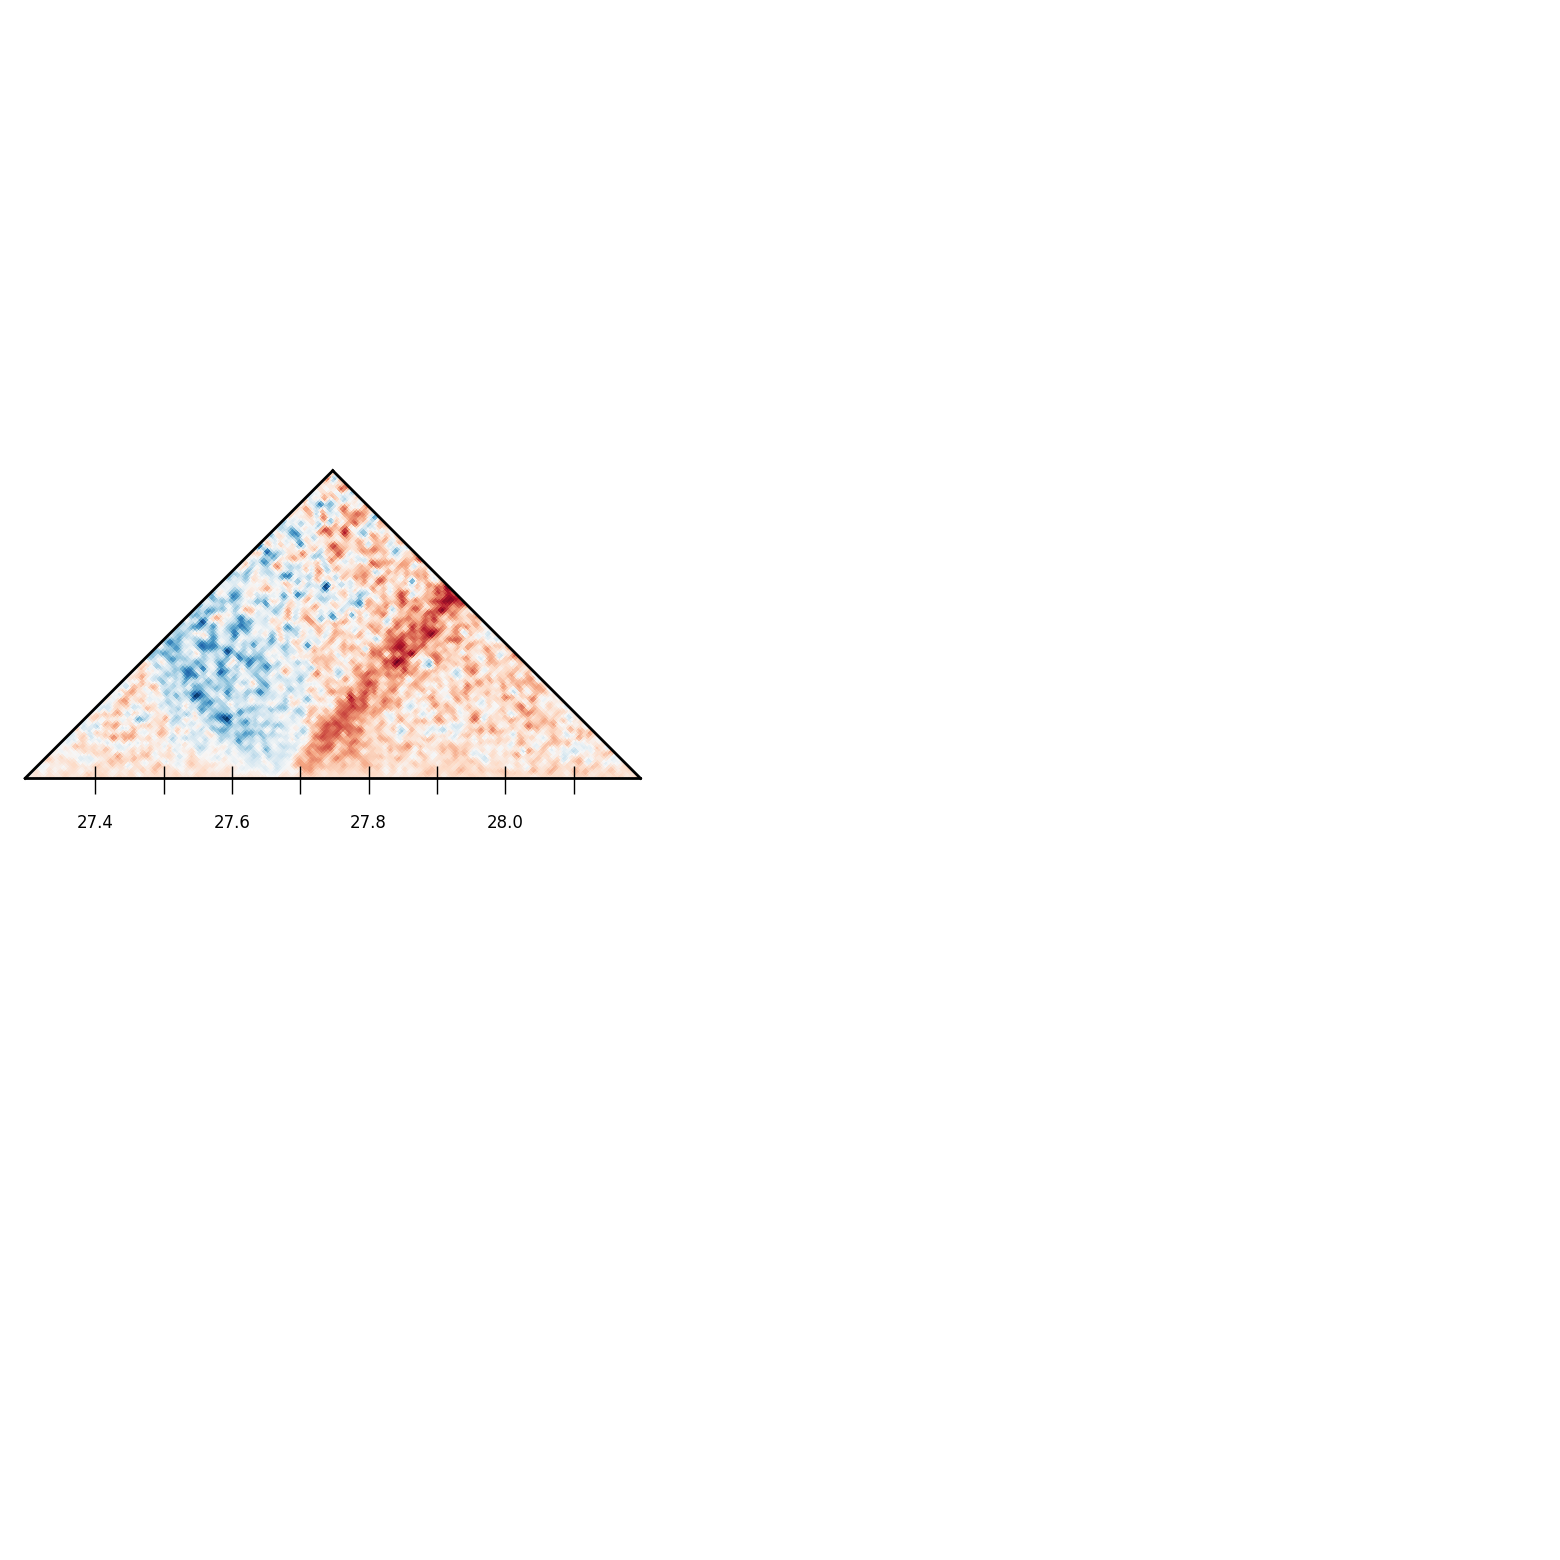

In [228]:
genome_hic_cool = cooler.Cooler('/wynton/group/capra/data/wynton_databases/4DN/GM12878/4DNFIXP4QG5B.mcool::resolutions/5000')

chrm = 'chr4'
wndw = 27262976
individual = 'EAS_CDX_female_HG00864'

target = get_target(chrm,wndw,wndw + 2**20,genome_hic_cool, 5000)

mat = visualize_map(target, wndw, 183)

In [ ]:
'/wynton/group/capra/data/wynton_databases/4DN/GM12878'